In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
from scipy import integrate
#
def ReadInitialRecord(MC, patient):
    #
    # Can be 91.
    init_file = "Fit-KBEPmodel-SteerVar-Init91.csv"
    if MC:
        patient_df = pd.read_csv("Patient-KBEPmodel-SteerVar.csv")
    else:
        patient_df = pd.read_csv("PatientData-Elife.csv")  #Replace with data set required
    #
    header_df = pd.read_csv("Header-KBEPmodel-SteerVar.csv")
    #
    if verbose:
        print(" ")
        print("First patient",patient)
        print("Patient dataframe:")
        display(patient_df)
        print(" ")
        print("MC header:")
        display(header_df)
    return header_df, patient_df, init_file

##############################################################################################################

def ReadPatientRecord(patient_df, patient):
    #
    this_patient_df = patient_df[patient_df["Patient"] == patient]
    out_file = "FitKBEPoutput/Fit-KBEPmodel-SteerVar" + str(patient) + ".csv"
    #
    if verbose:
        print(" ")
        print("Patient",patient)
        print("Output file",out_file)
    return out_file, this_patient_df


In [5]:
def patientData(patient, this_patient_df):
    #
    bigy0 = True
    if bigy0:
        print(" ")
        print("Initial PSA point given large error")
    #
    meas_days = np.array(this_patient_df["Day"])
    n_meas_days = len(meas_days)
    n_days = meas_days[n_meas_days - 1]
    #
    PSA_data = np.array(this_patient_df["PSA"])
    noPSAdata = np.isnan(PSA_data)
    withPSAdata = np.logical_not(noPSAdata)
    #
    n_data_points = len(this_patient_df)
    treat_period = np.zeros(n_data_points)
    treat_period = np.array(this_patient_df["Treatment"])
    days_array = np.linspace(0, n_days, n_days + 1)
    bool_meas_days = np.isin(days_array, meas_days)
    #
    # Catch error in input data which will cause crash if not fixed.
    if n_meas_days != np.sum(bool_meas_days):
        counts = np.bincount(meas_days)
        dup_day = np.where(counts > 1)[0]    
        print(" ")
        print("Error detected in input data for patient",patient)
        print("Duplicated day(s)",dup_day)
        print("Stop: at least one duplicated day.")
        sys.exit(0)    
    #
    # Create data arrays for fit
    xData = meas_days[withPSAdata]
    yData = PSA_data[withPSAdata]
    #
    # Create error arrays
    #xError = np.full(len(meas_days), 1/np.sqrt(12))[withPSAdata]
    #xError = np.full(len(meas_days), 1/(2*np.sqrt(12)))[withPSAdata]
    xError = np.full(len(meas_days), 1/(3*np.sqrt(12)))[withPSAdata]
    #xError = np.full(len(meas_days), 1)[withPSAdata]
    #xError = np.full(len(meas_days), 0.0)[withPSAdata]
    #
    #yError = np.full(len(meas_days), 0.1)[withPSAdata]
    #yError = np.full(len(meas_days), 0.5)[withPSAdata]
    yError = 0.1*np.sqrt(PSA_data[withPSAdata])
    #yError = 0.01*PSA_data[withPSAdata]
    #yError = np.full(len(meas_days), 1.0e-6)[withPSAdata]
    #
    if bigy0:
        yError[0] = 10
    #
    # Calculate treatment array from treatment schedule and start and finish  
    treat_day = np.zeros(n_days + 1)
    for m in range(0, n_meas_days - 1):
        treat_day[meas_days[m]:meas_days[m + 1]] = treat_period[m]            
    treat_day[meas_days[m + 1]] = treat_period[n_meas_days - 1]
    #
    t_diff = np.zeros(n_days)
    t_diff[0:n_days] = treat_day[1:n_days + 1] - treat_day[0:n_days]
    #
    t_start = days_array[np.where(np.abs(t_diff) == 1)[0]] + 1
    #
    n_temp = len(t_start)
    t_end = np.zeros(n_temp)
    t_end = t_start - 1
    t_start = np.insert(t_start, 0, 0)
    t_end = np.append(t_end, n_days)
    n_periods = len(t_start)
    #
    if verbose:
        print("Number of data points",n_data_points)
        print("Measured days (meas_days) \n",meas_days)
        print("n_days",n_days)
        print("days_array\n",days_array)
        print("Measured days (days_array[bool_meas_days]) \n",days_array[bool_meas_days])
        print("treat_day\n",treat_day)
        print("n_periods",n_periods)
        print("t_start",t_start,"t_end",t_end)
    #
    return (meas_days, PSA_data, treat_period, treat_day, xData, yData, xError, yError,
            n_data_points, n_periods, t_end, t_start)

<span style='font-size:x-large'>Plotting Data</span>


In [6]:
def plotData(patient, meas_days, PSA_data, treat_period):
    #
    n_meas_days = len(meas_days)
    n_days = meas_days[n_meas_days - 1]
    noPSAdata = np.isnan(PSA_data)
    withPSAdata = np.logical_not(noPSAdata)
    #
    if verbose:
        print(" ")
        print("Measured days \n",meas_days)
        print("Number of days",n_days)
        print("PSA \n",PSA_data)
        print(" ")
        print("Treatment\n",treat_period)
    #
    # Shade plot according to treatment array value
    color_tab = ['y', 'c', 'pink']
    #
    fig, axs = plt.subplots(1, 1, figsize = (12, 4))
    #
    axs.set_title('PSA for patient ' + str(patient)) 
    axs.set_xlabel('Time (days)')
    axs.set_ylabel('PSA')
    axs.errorbar(xData, yData, xerr = xError, yerr = yError, marker = '+', linestyle = '', color = 'b', label = "PSA")
    axs.plot(meas_days[noPSAdata], np.full_like(meas_days, 0.0)[noPSAdata], 
             marker = '.', linestyle = '', color = 'b', label = "no data")
    #axs.set_yscale('log')
    axs.grid(color = 'g')
    axs.set_xlim(0, np.amax(meas_days))
    #
    treat = False
    set_one = True
    #
    treat = treat_period[0]
    #
    for n_day in range(0, len(meas_days) - 1):
        if treat:
            if set_one:
                axs.axvspan(meas_days[n_day], meas_days[n_day + 1], alpha = 0.2, color = 'c', label = "T on")
                set_one = False
            else:
                axs.axvspan(meas_days[n_day], meas_days[n_day + 1], alpha = 0.2, color = 'c')
        treat = treat_period[n_day + 1]
    #
    axs.legend()
    #
    plt.tight_layout()
    plt.show()
    #
    return

In [7]:
##Listing data

def listDataXY(patient, this_patient_df, meas_days, PSA_data, treat_day, xData, yData, xError, yError):
    #
    print(" ")
    display(this_patient_df)
    #
    n_meas_days = len(meas_days)
    n_days = meas_days[n_meas_days - 1]
    #
    max_list = 40000
    print(" ")
    print(f"Patient {patient}, number of days {n_days}")
    print(f" Day  Treatment   PSA    xData  xError  yData   yError ")
    dM = 0
    dX = 0
    for nD in range(0, min(n_days + 1, max_list)):
        if (meas_days[dM] == nD):
            if  np.isnan(PSA_data[dM]):
                print(f"{nD:4.0f} {treat_day[nD]:8.0f}   {PSA_data[dM]:6.1f}")
            else:
                print(f"{nD:4.0f} {treat_day[nD]:8.0f}   {PSA_data[dM]:6.1f} ",
                      f"{xData[dX]:6.1f} {xError[dX]:6.2f}  {yData[dX]:6.1f}   {yError[dX]:6.2f}")
                dX += 1
            dM += 1
    #
    return

<span style='font-size:x-large'>Plot data and model</span>


In [8]:
def plotDataModel(patient, fitDone, full_model, meas_days, PSA_data, treat_day, Sarr, Rarr, PSA,
                 xData, yData, xError, yError):
    #
    n_meas_days = len(meas_days)
    n_days = meas_days[n_meas_days - 1]
    noPSAdata = np.isnan(PSA_data)
    withPSAdata = np.logical_not(noPSAdata)
    #
    days_arr = np.linspace(0, n_days, n_days + 1)
    print(" ")
    #
    fig, axs = plt.subplots(1, 1, figsize = (12, 4))
    #
    if fitDone:
        axs.set_title('PSA with fit for patient ' + str(patient)) 
    else:
        axs.set_title('PSA with initial model for patient ' + str(patient)) 
    #
    axs.set_xlabel('Time (days)')
    axs.set_ylabel('PSA')
    axs.plot(days_arr, PSA, linestyle = '-', color = 'r', marker = '', label = "Model")
    axs.errorbar(xData, yData, xerr = xError, yerr = yError, marker = '+', linestyle = '', color = 'b', label = "PSA")
    axs.plot(meas_days[noPSAdata], np.full_like(meas_days, 0.0)[noPSAdata], 
             marker = '.', linestyle = '', color = 'b', label = "no data")
    axs.set_xlim(np.min(days_arr), np.max(days_arr))
    #axs.set_yscale('log')
    axs.grid(color = 'g')
    #
    # Shade plot according to treat_day value
    set_one = True
    #
    treat = not treat_day[0]
    last = 0
    for n in range(0, n_days):
        if treat_day[n] == treat and n != n_days - 1:
            continue
        if treat:
            if set_one:
                axs.axvspan(days_arr[last], days_arr[n], alpha = 0.2, color = 'c', label = "T on")
                set_one = False
            else:
                axs.axvspan(days_arr[last], days_arr[n], alpha = 0.2, color = 'c')
        treat = treat_day[n + 1]
        last = n
    #
    axs.legend()
    #
    plt.tight_layout()
    plt.show()
    # 
    # Plot cell numbers from model
    if full_model:
        print(" ")
        fig, axs = plt.subplots(1, 2, figsize = (12, 4))
        #
        axs[0].set_title(r'$S$ for patient ' + str(patient)) 
        axs[0].set_xlabel('Time (days)')
        axs[0].set_ylabel(r'$S$')
        axs[0].plot(days_arr[:], Sarr[0:], linestyle = '-', color = 'r')
        axs[0].set_xlim(np.min(days_arr), np.max(days_arr))
        #axs[0].set_yscale('log')
        axs[0].grid(color = 'g')
        #
        # Shade plot according to treat_day value
        color_tab = ['y', 'c', 'pink']
        #
        treat = False
        set_one = True
        #
        treat = not treat_day[0]
        last = 0
        for n in range(0, n_days):
            if treat_day[n] == treat and n != n_days - 1:
                continue
            if treat:
                if set_one:
                    axs[0].axvspan(days_arr[last], days_arr[n], alpha = 0.2, color = 'c', label = "T on")
                    set_one = False
                else:
                    axs[0].axvspan(days_arr[last], days_arr[n], alpha = 0.2, color = 'c')
            treat = treat_day[n + 1]
            last = n
        #
        axs[0].legend()
        #
        axs[1].set_title(r'$R$ for patient ' + str(patient)) 
        axs[1].set_xlabel('Time (days)')
        axs[1].set_ylabel(r'$R$')
        axs[1].plot(days_arr[:], Rarr[:], linestyle = '-', color = 'r')
        axs[1].set_xlim(np.min(days_arr), np.max(days_arr))
        #axs[1].set_yscale('log')
        axs[1].grid(color = 'g')
        #
        # Shade plot according to treat_day value
        set_one = True
        #
        treat = not treat_day[0]
        last = 0
        for n in range(0, n_days):
            if treat_day[n] == treat and n != n_days - 1:
                continue
            if treat:
                if set_one:
                    axs[1].axvspan(days_arr[last], days_arr[n], alpha = 0.2, color = 'c', label = "T on")
                    set_one = False
                else:
                    axs[1].axvspan(days_arr[last], days_arr[n], alpha = 0.2, color = 'c')
            treat = treat_day[n + 1]
            last = n
            #
        axs[1].legend()
        #
        plt.tight_layout()
        plt.show()
    return

<span style='font-size:x-large'>Calculate model using fitting procedure</span>


In [9]:
def derivative(t, X, rS, rR, K, C, deltaS, alphaS, betaR, rhoS, rhoR, phiP, T):
    #
    dotX = np.zeros(3)
    dotX[0] = rS*(1 - T)*(1 - (X[0] + X[1])/K)*X[0] - deltaS*T*X[0] - alphaS*T*X[0] + betaR*(1 - T)*X[1]
    dotX[1] = rR*(1 - (C*X[0] + X[1])/K)*X[1] + alphaS*T*X[0] - betaR*(1 - T)*X[1]
    dotX[2] = rhoS*X[0] + rhoR*X[1] - phiP*X[2]
    #
    return dotX
#
def theModel(n_days, n_periods, t_start, t_end, treat_day, S0start, R0start, P0start, 
             rS, rR, K, C, deltaS, alphaS, betaR, rhoS, rhoR, phiP):
    '''
    Given number of days and treatment periods, start and end times of treatment and 
    array indicating whether treatment on or off, return S, D and P values for all times
    '''
    #
    lmbda = np.log(2)
    #
    # Arrays for global plots
    t_all = np.zeros(n_days + 1)
    T_all = np.zeros(n_days + 1).astype(bool)
    S_all = np.zeros(n_days + 1)
    R_all = np.zeros(n_days + 1)
    P_all = np.zeros(n_days + 1)
    dP_all = np.zeros(n_days + 1)
    #
    S0 = S0start
    R0 = R0start
    P0 = P0start
    #
    # Number of steps at end of last completed treatment cycle 
    n_last = 0
    #
    # Calculation for all days using solve_ivp.
    for n in range(0, n_periods):
        t_span = (t_start[n], t_end[n])
        T = treat_day[int(t_start[n])]
        #
        X0 = [S0, R0, P0]
        #
        sol = integrate.solve_ivp(derivative, t_span, X0, 
                                  args = (rS, rR, K, C, deltaS, alphaS, betaR, rhoS, rhoR, phiP, T), 
                                  dense_output = True)
        X = sol.y
        t_here = sol.t
        n_points = len(t_here)
        S0 = X[0, n_points - 1]
        R0 = X[1, n_points - 1]
        P0 = X[2, n_points - 1]
        #
        # Calculate solution with step size of 1 day (need to have set dense_output = True in solve_ivp call!)
        n_pts_cycle = int(t_end[n] - t_start[n] + 1)
        t_cycle = np.linspace(t_start[n], t_end[n], n_pts_cycle)
        X_sol = sol.sol(t_cycle)
        #S0 = X_sol[0, n_pts_cycle - 1]
        #R0 = X_sol[1, n_pts_cycle - 1]
        #P0 = X_sol[2, n_pts_cycle - 1]
        #
        t_all[n_last:n_last + n_pts_cycle] = t_cycle[0:n_pts_cycle]        
        T_all[n_last:n_last + n_pts_cycle] = T*np.ones(n_pts_cycle)
        S_all[n_last:n_last + n_pts_cycle] = X_sol[0, 0:n_pts_cycle]
        R_all[n_last:n_last + n_pts_cycle] = X_sol[1, 0:n_pts_cycle]
        P_all[n_last:n_last + n_pts_cycle] = X_sol[2, 0:n_pts_cycle]
        dP_all[n_last:n_last + n_pts_cycle] = rhoS*X_sol[0, :] + rhoR*X_sol[1, :] - phiP*X_sol[2, :]
        #
        n_last += n_pts_cycle
    #
    return t_all, T_all, S_all, R_all, P_all, dP_all

In [10]:
#initial parameters for fit

import scipy.odr as odr
from scipy.optimize import least_squares
#
def prepareFit(MC, use_MC_init, use_fitoutput, init_file):
    #
    # How are initial values of fit parameters set?
    print(" ")
    if MonteCarlo or use_MC_init:
        print("Monte Carlo data or use of MC initialisation requested")
    elif (use_fitoutput):
        print("Initial parameter file",init_file)
    else:
        print("Initial parameters hardwired in code")
    #
    if MonteCarlo or use_MC_init:
        S0_ini = header_df['S0'][0]
        R0_ini = header_df['R0'][0]
        P0_ini = header_df['P0'][0]
        rS_ini = header_df['rS'][0]
        rR_ini = header_df['rR'][0]
        K_ini = header_df['K'][0]
        C_ini = header_df['C'][0]
        deltaS_ini = header_df['deltaS'][0]
        alphaS_ini = header_df['alphaS'][0]
        betaR_ini = header_df['betaR'][0] 
        rhoS_ini = header_df['rhoS'][0] 
        rhoR_ini = header_df['rhoR'][0] 
        phiP_ini = header_df['phiP'][0]
        #
    elif use_fitoutput:
        #
        # Read initial parameter values
        fitinput_df = pd.read_csv(init_file, index_col = False)
        #              
        S0_ini = fitinput_df['S0'][0]
        R0_ini = fitinput_df['R0'][0]
        P0_ini = fitinput_df['P0'][0]
        rS_ini = fitinput_df['rS'][0]
        rR_ini = fitinput_df['rR'][0]
        K_ini = fitinput_df['K'][0]
        C_ini = fitinput_df['C'][0]
        deltaS_ini = fitinput_df['deltaS'][0]
        alphaS_ini = fitinput_df['alphaS'][0]
        betaR_ini = fitinput_df['betaR'][0] 
        rhoS_ini = fitinput_df['rhoS'][0] 
        rhoR_ini = fitinput_df['rhoR'][0] 
        phiP_ini = fitinput_df['phiP'][0]
    else:
        #S0_ini = 4500
        #R0_ini = 120
        #P0_ini = 10
        #rS_ini = 6.7e-3
        #rR_ini = 1.6e-3
        #K_ini = 7e4
        #C_ini = 1       # Very good idea to have this set at one!
        #deltaS_ini = 0.03
        #alphaS_ini = 0.006
        #betaR_ini = 0.05
        #rhoS_ini = 1.874e-4 
        #rhoR_ini = 1.874e-5 
        #phiP_ini = 0.0856
        #
        S0_ini = 4800
        R0_ini = 100
        P0_ini = 12
        rS_ini = 7.7e-3
        rR_ini = 2.6e-3
        K_ini = 8e4
        C_ini = 1       # Very good idea to have this set at one!
        deltaS_ini = 0.04
        alphaS_ini = 0.003
        betaR_ini = 0.03
        rhoS_ini = 2.0e-4 
        rhoR_ini = 1.0e-5 
        phiP_ini = 0.09
    #
    pIn = []
    uBs = []
    lBs = []
    #
    pIn.append(S0_ini)
    pIn.append(R0_ini)
    pIn.append(P0_ini)
    if use_rS:
        pIn.append(rS_ini)
    if use_rR:
        pIn.append(rR_ini)
    if use_K:
        pIn.append(K_ini)
    if use_C:
        pIn.append(C_ini)
    if use_deltaS:
        pIn.append(deltaS_ini)
    if use_alphaS:
        pIn.append(alphaS_ini)
    if use_betaR:
        pIn.append(betaR_ini)
    if use_rhoS:
        pIn.append(rhoS_ini) 
    if use_rhoR:
        pIn.append(rhoR_ini) 
    if use_phiP:
        pIn.append(phiP_ini)
    #
    # Set lower bounds of fit parameters
    #          S0
    lBs.append(0.0)
    #          R0
    lBs.append(0.0)
    #          P0
    lBs.append(0.0)
    if use_rS:
        lBs.append(0.0)
    if use_rR:
        lBs.append(0.0)
    if use_K:
        lBs.append(0.0)
    if use_C:
        lBs.append(0.0)
    if use_deltaS:
        lBs.append(0.0)
    if use_alphaS:
        lBs.append(0.0)
    if use_betaR:
        lBs.append(0.0)
    if use_rhoS:
        lBs.append(0.0) 
    if use_rhoR:
        lBs.append(0.0) 
    if use_phiP:
        lBs.append(0.0)
    #
    # Set upper bounds of fit parameters
    #          S0
    uBs.append(np.inf)
    #          R0
    uBs.append(np.inf)
    #          P0
    uBs.append(np.inf)
    if use_rS:
        uBs.append(np.inf)
    if use_rR:
        uBs.append(np.inf)
    if use_K:
        uBs.append(np.inf)
    if use_C:
        uBs.append(np.inf)
    if use_deltaS:
        uBs.append(np.inf)
    if use_alphaS:
        uBs.append(np.inf)
    if use_betaR:
        uBs.append(np.inf)
    if use_rhoS:
        uBs.append(np.inf)
    if use_rhoR:
        uBs.append(np.inf)
    if use_phiP:
        uBs.append(np.inf)
    #
    nParams = len(pIn)
    print("Number of parameters",nParams)
    #
    with np.printoptions(precision = 2):
        params = "S0, R0, P0"
        if use_rS:
            params += ", rS"
        if use_rR:
            params += ", rR"
        if use_K:
            params += ", K"
        if use_C:
            params += ", C"
        if use_deltaS:
            params += ", deltaS"
        if use_alphaS:
            params += ", alphaS"
        if use_betaR:
            params += ", betaR"
        if use_rhoS:
            params += ", rhoS"
        if use_rhoR:
            params += ", rhoR"
        if use_phiP:
            params += ", phiP"
        print("Free parameters are " + params)
        print("Initial parameter values: \n",np.array(pIn))
        print("Lower bounds: \n",np.array(lBs))
        print("Upper bounds: \n",np.array(uBs))
    #
    if MonteCarlo:
        pIn = rng.normal(1, 1e-20, nParams)*pIn
        with np.printoptions(precision = 2):
            print("After randomisation, initial parameter values \n",np.array(pIn))
    #
    allOK = True
    for nB in range(0, nParams):
        if pIn[nB] < lBs[nB] or pIn[nB] > uBs[nB]:
            print(f"Input variable out of range: pIn[{nB:d}] = {pIn[nB]:5.2e}.")
            print(f"lBs[{nB:d}] = {lBs[nB]:5.2e} and uBs[{nB:d}] = {uBs[nB]:5.2e}")
            allOK = False
    if not allOK:
        print(" ")
        print("Stop: initial parameters and bounds inconsistent")
        sys.exit(0)
    print(" ")
    print("Full parameter list:")
    print(f"S0_ini,     R0_ini,     P0_ini,     rS_ini,     rR_ini,      K_ini,      C_ini")
    print(f"{S0_ini:6.3e}, {R0_ini:10.3e}, {P0_ini:10.3e}, {rS_ini:10.3e}, {rR_ini:10.3e}, ", 
          f"{K_ini:10.3e}, {C_ini:10.3e}")
    print(f"deltaS_ini,  alphaS_ini,   betaR_ini,   rhoS_ini,   rhoR_ini,    phiP_ini")
    print(f"{deltaS_ini:6.3e}, {alphaS_ini:10.3e}, {betaR_ini:10.3e}, {rhoS_ini:10.3e}, ",
          f"{rhoR_ini:10.3e}, {phiP_ini:10.3e}")
    #
    return (pIn, lBs, uBs, S0_ini, R0_ini, P0_ini, 
            rS_ini, rR_ini, K_ini, C_ini, deltaS_ini, alphaS_ini, betaR_ini, rhoS_ini, rhoR_ini, phiP_ini)

In [11]:
## chi sq calculation
def fitChi(p, n_days, n_periods, t_start, t_end, treat_day, x, y, xerr, yerr):
    '''
    Calculation of chi for fit function and data.
    '''
    #
    daysFit = np.linspace(0, n_days, n_days + 1)
    #
    lmbda = np.log(2)
    #
    # Extract model parameters from least_squares parameter array p[].
    ind = 0
    S0 = p[ind] 
    ind += 1
    R0 = p[ind] 
    ind += 1
    P0 = p[ind] 
    ind += 1
    if use_rS:
        rS = p[ind]
        ind += 1
    else:
        rS = rS_ini
    if use_rR:
        rR = p[ind]
        ind += 1
    else:
        rR = rR_ini
    if use_K:
        K = p[ind]
        ind += 1
    else:
        K = K_ini
    if use_C:
        C = p[ind]
        ind += 1
    else:
        C = C_ini
    if use_deltaS:
        deltaS = p[ind]
        ind += 1
    else:
        deltaS = deltaS_ini
    if use_alphaS:
        alphaS = p[ind]
        ind += 1
    else:
        alphaS = alphaS_ini
    if use_betaR:
        betaR = p[ind]
        ind += 1
    else:
        betaR = betaR_ini
    if use_rhoS:
        rhoS = p[ind]
        ind += 1
    else:
        rhoS = rhoS_ini
    if use_rhoR:
        rhoR = p[ind]
        ind += 1
    else:
        rhoR = rhoR_ini
    if use_phiP:
        phiP = p[ind]
        ind += 1
    else:
        phiP = phiP_ini
    #
    # Identify days on which measurements performed in complete days array
    boolMeasDays = np.isin(daysFit, xData)
    #
    # Calculation of model for all days with current values of parameters
    t_all, T_all, S_all, R_all, P_all, dP_all = \
    theModel(n_days, n_periods, t_start, t_end, treat_day, S0, R0, P0,
             rS, rR, K, C, deltaS, alphaS, betaR, rhoS, rhoR, phiP)
    #
    chi = (yData - P_all[boolMeasDays])/(np.sqrt(yerr**2 + dP_all[boolMeasDays]**2*xerr**2))
    #
    # Calculate chi**2 and enter in global list so can plot progress of least_squares optimisation
    chi2iter = np.sum(chi**2)
    iteration = len(chi2global)
    if iteration%100 == 0 and verbose:
        print(f"Iteration {iteration}, chi2 = {chi2iter:.2e}")
    #
    chi2global.append(chi2iter)
    S0hist.append(S0)
    R0hist.append(R0)
    P0hist.append(P0)
    rShist.append(rS)
    rRhist.append(rR)
    Khist.append(K)
    Chist.append(C)
    deltaShist.append(deltaS)
    alphaShist.append(alphaS)
    betaRhist.append(betaR)
    rhoShist.append(rhoS)
    rhoRhist.append(rhoR)
    phiPhist.append(phiP)
    #
    return chi

<span style='font-size:x-large'>Do fit</span>


In [12]:
def doFit(patient, meas_days, xData, yData, xError, yError, pIn, lBs, uBs):
    #
    if verbose:
        print(" ")
        print("pIn",pIn)
        print("lBs",lBs)
        print("uBs",uBs)
    #
    out = least_squares(fitChi, pIn, args = (n_days,  n_periods, t_start, t_end, treat_day, 
                                             xData, yData, xError, yError), 
                        bounds = (lBs, uBs), ftol = 1e-10)
    #
    # Plot chi2 with Iteration
    nIter = len(chi2global)
    iteration = np.linspace(0, nIter - 1, nIter)
    #
    print(" ")
    print("Fit history")
    one_array = np.ones(nIter)
    fig, axs = plt.subplots(3, 5, figsize = (10, 6))
    #
    axs[0, 0].set_title(r'$\chi^2$ with iteration') 
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel(r'$\chi^2$')
    axs[0, 0].plot(iteration, chi2global, linestyle = '-', marker = '', color = 'r')
    axs[0, 0].set_yscale('log')
    axs[0, 0].grid(color = 'g')
    #
    axs[0, 1].set_title(r'$S_0$ with iteration') 
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel(r'$S_0$')
    axs[0, 1].plot(iteration, S0hist, linestyle = '-', marker = '', color = 'b')
    axs[0, 1].plot(iteration, S0_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[0, 1].set_yscale('log')
    axs[0, 1].grid(color = 'g')
    #
    axs[0, 2].set_title(r'$R_0$ with iteration') 
    axs[0, 2].set_xlabel('Iteration')
    axs[0, 2].set_ylabel(r'$R_0$')
    axs[0, 2].plot(iteration, R0hist, linestyle = '-', marker = '', color = 'b')
    axs[0, 2].plot(iteration, R0_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[0, 2].set_yscale('log')
    axs[0, 2].grid(color = 'g')
    #
    axs[0, 3].set_title(r'$P_0$ with iteration') 
    axs[0, 3].set_xlabel('Iteration')
    axs[0, 3].set_ylabel(r'$P_0$')
    axs[0, 3].plot(iteration, P0hist, linestyle = '-', marker = '', color = 'b')
    axs[0, 3].plot(iteration, P0_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[0, 3].set_yscale('log')
    axs[0, 3].grid(color = 'g')
    #
    axs[0, 4].set_title(r'$r_S$ with Iteration') 
    axs[0, 4].set_xlabel('Iteration')
    axs[0, 4].set_ylabel(r'$r_S$')
    axs[0, 4].plot(iteration, rShist, linestyle = '-', marker = '', color = 'b')
    axs[0, 4].plot(iteration, rS_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[0, 4].set_yscale('log')
    axs[0, 4].grid(color = 'g')
    #
    axs[1, 0].set_title(r'$r_R$ with Iteration') 
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel(r'$r_R$')
    axs[1, 0].plot(iteration, rRhist, linestyle = '-', marker = '', color = 'b')
    axs[1, 0].plot(iteration, rR_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(color = 'g')
    #
    axs[1, 1].set_title(r'$K$ with Iteration') 
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel(r'$K$')
    axs[1, 1].plot(iteration, Khist, linestyle = '-', marker = '', color = 'b')
    axs[1, 1].plot(iteration, K_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[1, 1].set_yscale('log')
    axs[1, 1].grid(color = 'g')
    #
    axs[1, 2].set_title(r'$C$ with Iteration') 
    axs[1, 2].set_xlabel('Iteration')
    axs[1, 2].set_ylabel(r'$C$')
    axs[1, 2].plot(iteration, Chist, linestyle = '-', marker = '', color = 'b')
    axs[1, 2].plot(iteration, C_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[1, 2].set_yscale('log')
    axs[1, 2].grid(color = 'g')
    #
    axs[1, 3].set_title(r'$\delta_S$ with Iteration') 
    axs[1, 3].set_xlabel('Iteration')
    axs[1, 3].set_ylabel(r'$\delta_S$')
    axs[1, 3].plot(iteration, deltaShist, linestyle = '-', marker = '', color = 'b')
    axs[1, 3].plot(iteration, deltaS_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[1, 3].set_yscale('log')
    axs[1, 3].grid(color = 'g')
    #
    axs[1, 4].set_title(r'$\alpha_S$ with Iteration') 
    axs[1, 4].set_xlabel('Iteration')
    axs[1, 4].set_ylabel(r'$\alpha_S$')
    axs[1, 4].plot(iteration, alphaShist, linestyle = '-', marker = '', color = 'b')
    axs[1, 4].plot(iteration, alphaS_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[1, 4].set_yscale('log')
    axs[1, 4].grid(color = 'g')
    #
    axs[2, 0].set_title(r'$\beta_R$ with Iteration') 
    axs[2, 0].set_xlabel('Iteration')
    axs[2, 0].set_ylabel(r'$\beta_R$')
    axs[2, 0].plot(iteration, betaRhist, linestyle = '-', marker = '', color = 'b')
    axs[2, 0].plot(iteration, betaR_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[2, 0].set_yscale('log')
    axs[2, 0].grid(color = 'g')
    #
    axs[2, 1].set_title(r'$\rho_S$ with Iteration') 
    axs[2, 1].set_xlabel('Iteration')
    axs[2, 1].set_ylabel(r'$\rho_S$')
    axs[2, 1].plot(iteration, rhoShist, linestyle = '-', marker = '', color = 'b')
    axs[2, 1].plot(iteration, rhoS_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[2, 1].set_yscale('log')
    axs[2, 1].grid(color = 'g')
    #
    axs[2, 2].set_title(r'$\rho_R$ with Iteration') 
    axs[2, 2].set_xlabel('Iteration')
    axs[2, 2].set_ylabel(r'$\rho_R$')
    axs[2, 2].plot(iteration, rhoRhist, linestyle = '-', marker = '', color = 'b')
    axs[2, 2].plot(iteration, rhoR_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[2, 2].set_yscale('log')
    axs[2, 2].grid(color = 'g')
    #
    axs[2, 3].set_title(r'$\phi_P$ with Iteration') 
    axs[2, 3].set_xlabel('Iteration')
    axs[2, 3].set_ylabel(r'$\phi_P$')
    axs[2, 3].plot(iteration, phiPhist, linestyle = '-', marker = '', color = 'b')
    axs[2, 3].plot(iteration, phiP_ini*one_array, linestyle = '--', marker = '', color = 'r')
    axs[2, 3].set_yscale('log')
    axs[2, 3].grid(color = 'g')
    #
    axs[2, 4].axis('off')
    #
    plt.tight_layout()
    plt.show()    
    #
    # Check fit success
    fitOK = out.success
    if not fitOK:
        print(" ")
        print("Fit failed to converge")
    #
    #  Extract fitted parameters and their errors
    pF = out.x
    #
    ind = 0
    S0_f = pF[ind]
    ind += 1
    R0_f = pF[ind]
    ind += 1
    P0_f = pF[ind]
    ind += 1
    if use_rS:
        rS_f = pF[ind]
        ind += 1
    else:
        rS_f = rS_ini
    if use_rR:
        rR_f = pF[ind]
        ind += 1
    else:
        rR_f = rR_ini
    if use_K:
        K_f = pF[ind]
        ind += 1
    else:
        K_f = K_ini
    if use_C:
        C_f = pF[ind]
        ind += 1
    else:
        C_f = C_ini
    if use_deltaS:
        deltaS_f = pF[ind]
        ind += 1
    else:
        deltaS_f = deltaS_ini
    if use_alphaS:
        alphaS_f = pF[ind]
        ind += 1
    else:
        alphaS_f = alphaS_ini
    if use_betaR:
        betaR_f = pF[ind]
        ind += 1
    else:
        betaR_f = betaR_ini
    if use_rhoS:
        rhoS_f = pF[ind]
        ind += 1
    else:
        rhoS_f = rhoS_ini
    if use_rhoR:
        rhoR_f = pF[ind]
        ind += 1
    else:
        rhoR_f = rhoR_ini
    if use_phiP:
        phiP_f = pF[ind]
        ind += 1
    else:
        phiP_f = phiP_ini
    #
    #   Calculate chis**2 per point, summed chi**2 and chi**2/NDF
    chisqArr = fitChi(pF, n_days, n_periods, t_start, t_end, treat_day, xData, yData, xError, yError)**2
    chisq = np.sum(chisqArr)
    nPoints = len(xData)
    nParams = len(pIn)
    NDF = nPoints - nParams
    redchisq = chisq/NDF
    #
    S0vals.append(S0_f)
    R0vals.append(R0_f)
    P0vals.append(P0_f)
    rSvals.append(rS_f)
    rRvals.append(rR_f)
    Kvals.append(K_f)
    Cvals.append(C_f)
    deltaSvals.append(deltaS_f)
    alphaSvals.append(alphaS_f)
    betaRvals.append(betaR_f)
    rhoSvals.append(rhoS_f)
    rhoRvals.append(rhoR_f)
    phiPvals.append(phiP_f)
    chiSqvals.append(redchisq)
    #
    np.set_printoptions(precision = 4)
    if verbose:
        print(" ")
        print("Number of iterations",nIter)
        print(f"Final chi2 value {chi2global[nIter - 1]:5.2e} (not necessarily minimum!).")
        print(" ")
        print("chisq per point = \n",chisqArr)
        #
    print(" ")
    print("Fit results - chisq = {:5.2e}, chisq/NDF = {:5.2e}.".format(chisq, redchisq))
    #
    # Compute covariance
    jMat = out.jac
    jMat2 = np.dot(jMat.T, jMat)
    detJmat2 = np.linalg.det(jMat2)
    #
    # Get errors, check whether jacobian matrix can be inverted 
    #
    P0_e = 0.0
    S0_e = 0.0
    R0_e = 0.0
    rS_e = 0.0
    rR_e = 0.0
    K_e = 0.0
    C_e = 0.0
    deltaS_e = 0.0
    alphaS_e = 0.0
    betaR_e = 0.0
    rhoS_e = 0.0
    rhoR_e = 0.0
    phiP_e = 0.0
    #    
    if detJmat2 < 1e-120:
        print(" ")
        print("Value of detJmat2 is",detJmat2)
        print("Jacobian matrix cannot be inverted, error set to zero.")
    else:
        #
        # Covariance matrix is OK, calculate errors
        if verbose:
            print(" ")
            print("Jacobian matrix inverted successfully.")
        cv = np.linalg.inv(jMat2)
        ind = 0
        S0_e  = np.sqrt(cv[ind, ind])
        ind += 1
        R0_e  = np.sqrt(cv[ind, ind])
        ind += 1
        P0_e  = np.sqrt(cv[ind, ind])
        ind += 1
        if use_rS:
            rS_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_rR:
            rR_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_K:
            K_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_C:
            C_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_deltaS:
            deltaS_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_alphaS:
            alphaS_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_betaR:
            betaR_e = np.sqrt(cv[ind, ind])
            ind += 1
        if use_rhoS:
            rhoS_e  = np.sqrt(cv[ind, ind])
            ind += 1
        if use_rhoR:
            rhoR_e  = np.sqrt(cv[ind, ind])
            ind += 1
        if use_phiP:
            phiP_e  = np.sqrt(cv[ind, ind])
    #
    print(" ")
    print("Fit results - returned parameters:")
    print(f"S0 = {S0_f:5.3e} +- {S0_e:5.3e} (cf. {S0_ini:5.2e})")
    print(f"R0 = {R0_f:5.3e} +- {R0_e:5.3e} (cf. {R0_ini:5.2e})")
    print(f"P0 = {P0_f:5.3e} +- {P0_e:5.3e} (cf. {P0_ini:5.2e})")
    if use_rS:
        print(f"rS = {rS_f:5.3e} +- {rS_e:5.5e} (cf. {rS_ini:5.2e})")
    if use_rR:
        print(f"rR = {rR_f:5.3e} +- {rR_e:5.5e} (cf. {rR_ini:5.2e})")
    if use_K:
        print(f"K = {K_f:5.3e} +- {K_e:5.5e} (cf. {K_ini:5.2e})")
    if use_C:
        print(f"C = {C_f:5.3e} +- {C_e:5.3e} (cf. {C_ini:5.2e})")
    if use_deltaS:
        print(f"deltaS = {deltaS_f:5.5e} +- {deltaS_e:5.3e} (cf. {deltaS_ini:5.2e})")
    if use_alphaS:
        print(f"alphaS = {alphaS_f:5.3e} +- {alphaS_e:5.3e} (cf. {alphaS_ini:5.2e})")
    if use_betaR:
        print(f"betaR = {betaR_f:5.3e} +- {betaR_e:5.3e} (cf. {betaR_ini:5.2e})")
    if use_rhoS:
        print(f"rhoS = {rhoS_f:5.3e} +- {rhoS_e:5.3e} (cf. {rhoS_ini:5.2e})")
    if use_rhoR:
        print(f"rhoR = {rhoR_f:5.3e} +- {rhoR_e:5.3e} (cf. {rhoR_ini:5.2e})")
    if use_phiP:
        print(f"phiP = {phiP_f:5.3e} +- {phiP_e:5.3e} (cf. {phiP_ini:5.2e})")
    #
    # Write out fit results
    #
    fitoutput_df = pd.DataFrame({'Patient':patient,
                                 'use_rS':use_rS,
                                 'use_rR':use_rR,
                                 'use_K':use_K,
                                 'use_C':use_C,
                                 'use_deltaS':use_deltaS,                             
                                 'use_alphaS':use_alphaS,
                                 'use_betaR':use_betaR,
                                 'use_rhoS':use_rhoS, 
                                 'use_rhoR':use_rhoR, 
                                 'use_phiP':use_phiP,
                                 'redChi2': redchisq, 
                                 'S0': S0_f, 
                                 'S0_e': S0_e, 
                                 'R0': R0_f, 
                                 'R0_e': R0_e, 
                                 'P0': P0_f, 
                                 'P0_e': P0_e, 
                                 'rS': rS_f, 
                                 'rS_e': rS_e, 
                                 'rR': rR_f, 
                                 'rR_e': rR_e, 
                                 'K': K_f, 
                                 'K_e': K_e, 
                                 'C': C_f, 
                                 'C_e': C_e, 
                                 'deltaS': deltaS_f, 
                                 'deltaS_e': deltaS_e, 
                                 'alphaS': alphaS_f, 
                                 'alphaS_e': alphaS_e, 
                                 'betaR': betaR_f, 
                                 'betaR_e': betaR_e, 
                                 'rhoS': rhoS_f, 
                                 'rhoS_e': rhoS_e, 
                                 'rhoR': rhoR_f, 
                                 'rhoR_e': rhoR_e, 
                                 'phiP': phiP_f, 
                                 'phiP_e': phiP_e,
                                 }, index = [0])
    #
    fitoutput_df.to_csv(out_file, index = False)
    #
    # Calculation of model for all days.
    t_all, T_all, Sarr_f, Rarr_f, PSA_f, dP_all = \
    theModel(n_days, n_periods, t_start, t_end, treat_day, S0_f, R0_f, P0_f, 
             rS_f, rR_f, K_f, C_f, deltaS_f, alphaS_f, betaR_f, rhoS_f, rhoR_f, phiP_f)
    #
    return Sarr_f, Rarr_f, PSA_f

Date and time  2024-05-10 16:03:21.788659
 
Initial parameters hardwired in code
Number of parameters 11
Free parameters are S0, R0, P0, rS, rR, K, C, deltaS, rhoS, rhoR, phiP
Initial parameter values: 
 [4.8e+03 1.0e+02 1.2e+01 7.7e-03 2.6e-03 8.0e+04 1.0e+00 4.0e-02 2.0e-04
 1.0e-05 9.0e-02]
Lower bounds: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Upper bounds: 
 [inf inf inf inf inf inf inf inf inf inf inf]
 
Full parameter list:
S0_ini,     R0_ini,     P0_ini,     rS_ini,     rR_ini,      K_ini,      C_ini
4.800e+03,  1.000e+02,  1.200e+01,  7.700e-03,  2.600e-03,   8.000e+04,  1.000e+00
deltaS_ini,  alphaS_ini,   betaR_ini,   rhoS_ini,   rhoR_ini,    phiP_ini
4.000e-02,  3.000e-03,  3.000e-02,  2.000e-04,   1.000e-05,  9.000e-02
 
Analysis for index 0 , patient 1004
 
Initial PSA point given large error
 


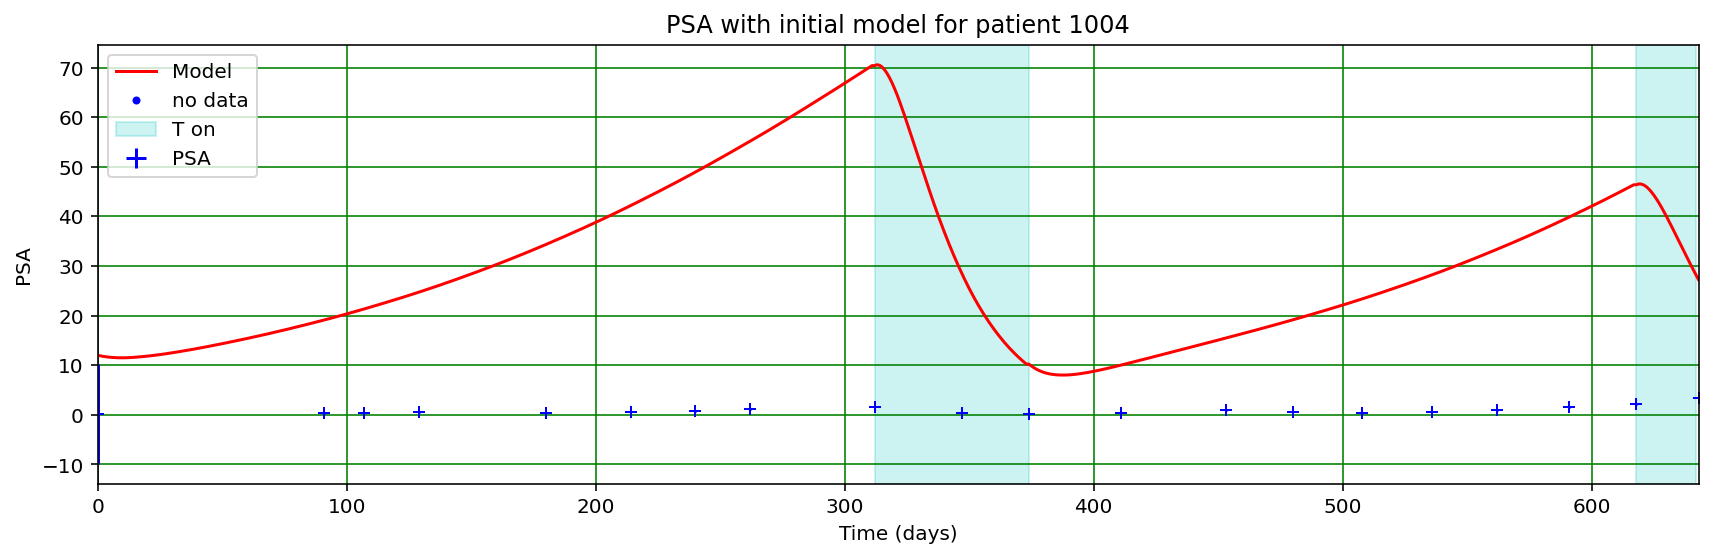

 
Fit history


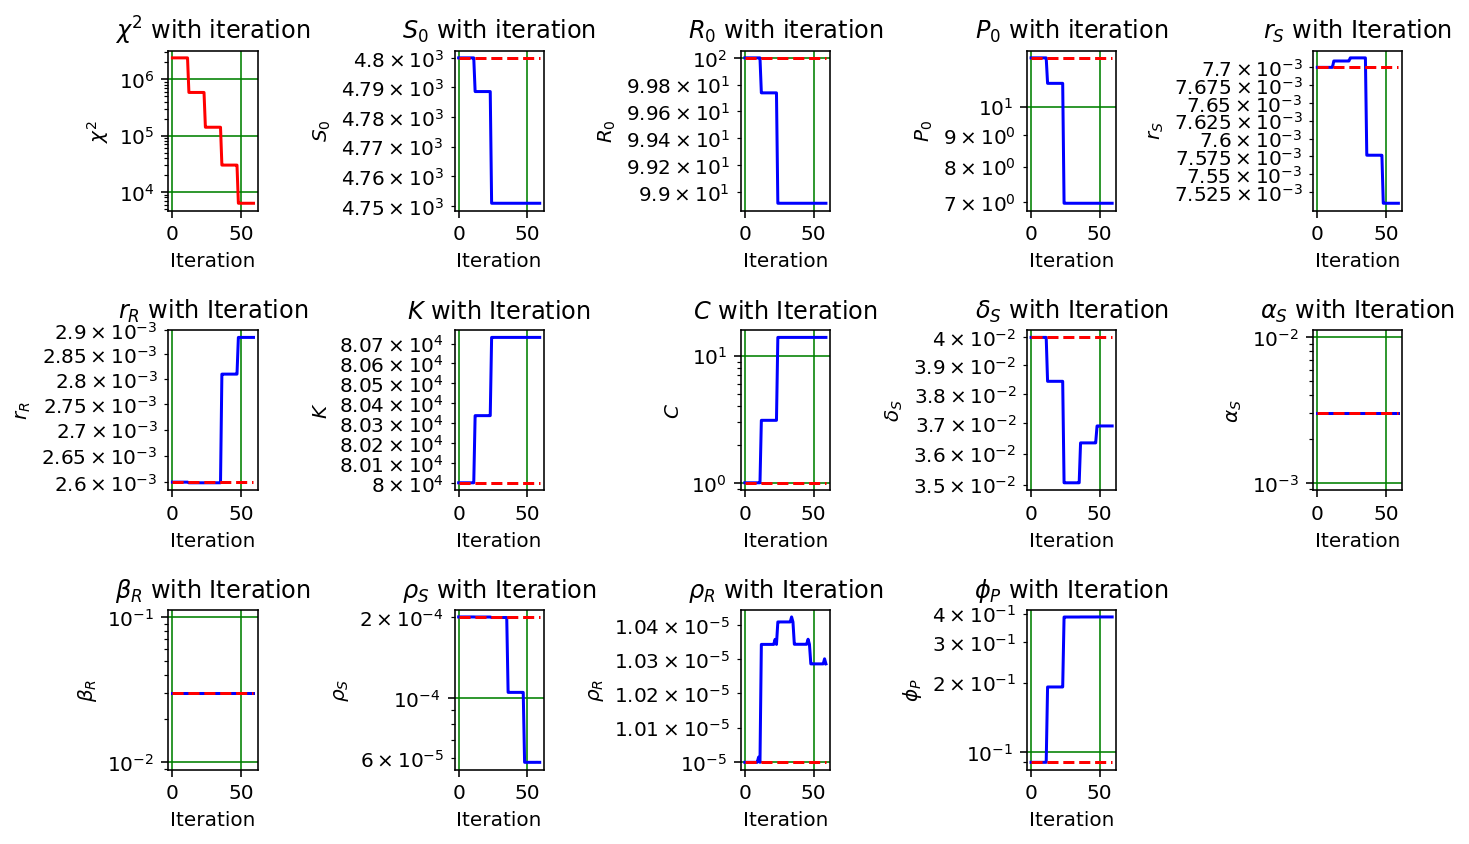

 
Fit results - chisq = 6.32e+03, chisq/NDF = 7.02e+02.
 
Fit results - returned parameters:
S0 = 4.751e+03 +- 1.883e+06 (cf. 4.80e+03)
R0 = 9.892e+01 +- 4.844e+04 (cf. 1.00e+02)
P0 = 6.975e+00 +- 9.856e+00 (cf. 1.20e+01)
rS = 7.510e-03 +- 9.16050e-04 (cf. 7.70e-03)
rR = 2.885e-03 +- 1.90741e-01 (cf. 2.60e-03)
K = 8.073e+04 +- 3.21133e+07 (cf. 8.00e+04)
C = 1.394e+01 +- 1.712e+02 (cf. 1.00e+00)
deltaS = 3.69147e-02 +- 9.349e-03 (cf. 4.00e-02)
rhoS = 5.775e-05 +- 2.297e-02 (cf. 2.00e-04)
rhoR = 1.029e-05 +- 4.113e-03 (cf. 1.00e-05)
phiP = 3.866e-01 +- 2.903e-02 (cf. 9.00e-02)
 
Patient data with fitted model
 


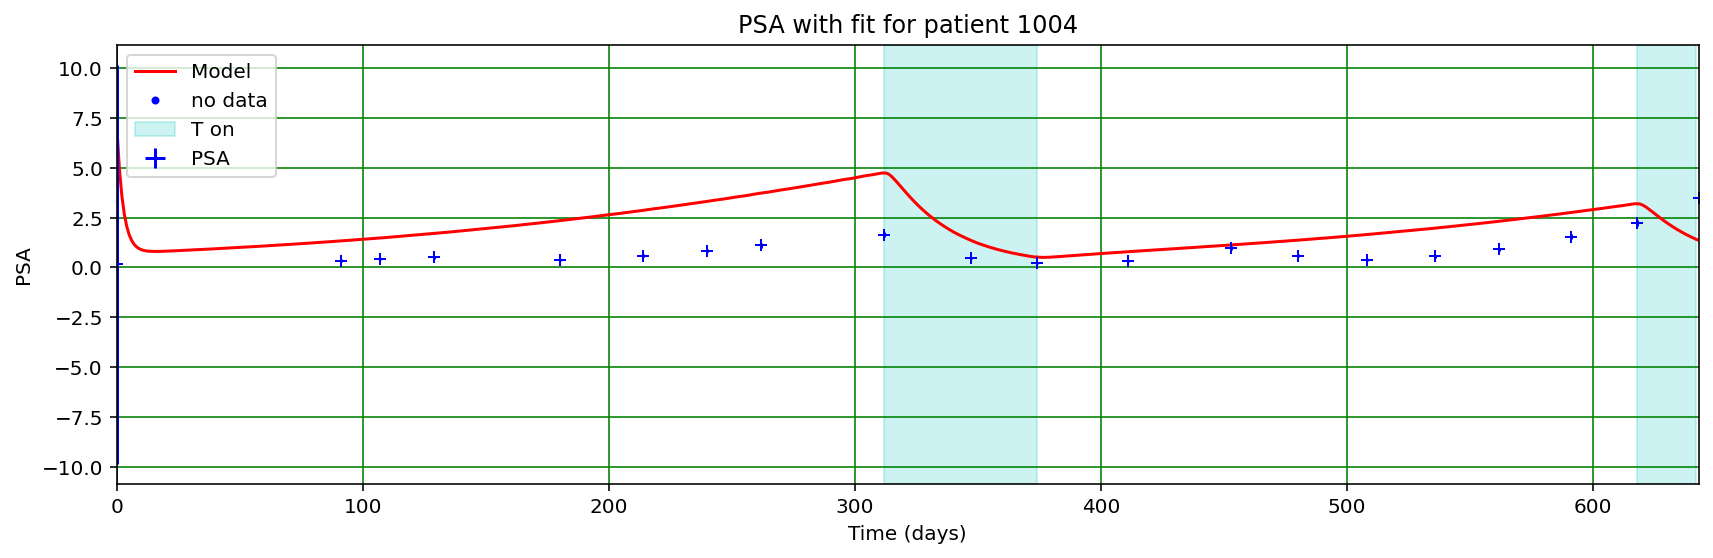

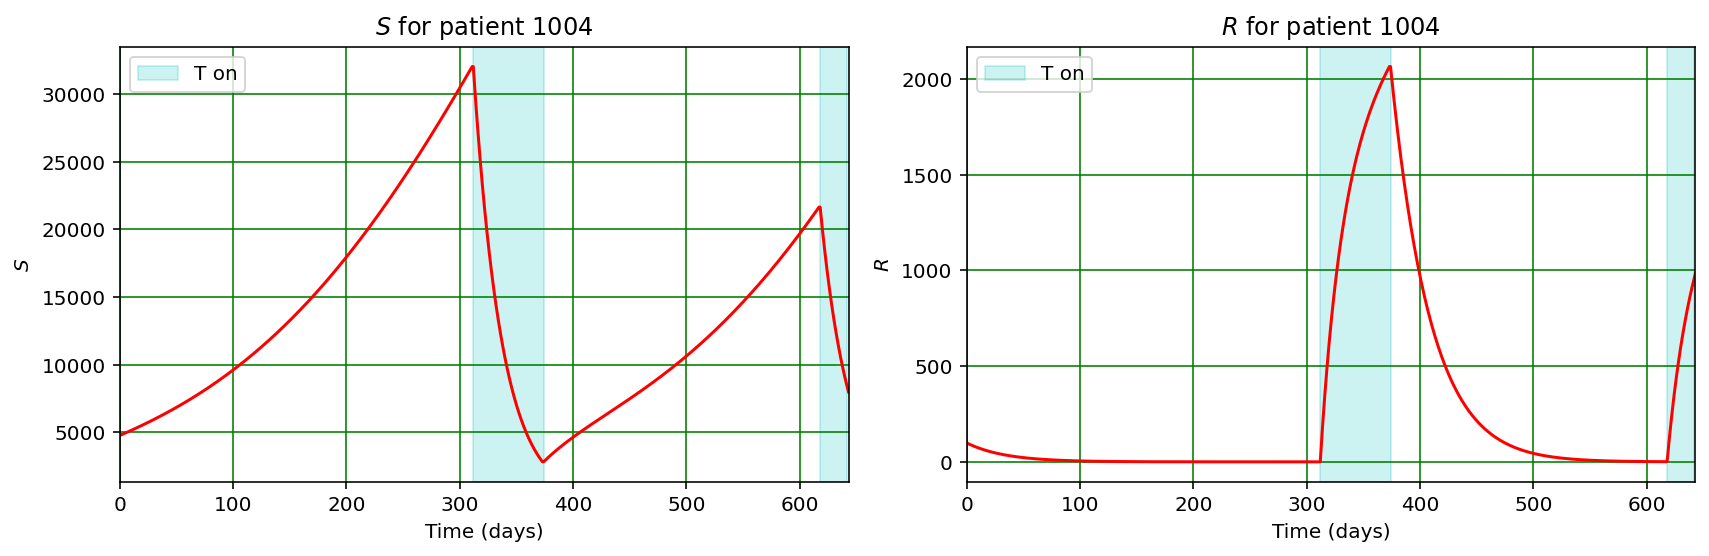

 
Analysis for index 1 , patient 1005
 
Initial PSA point given large error
 


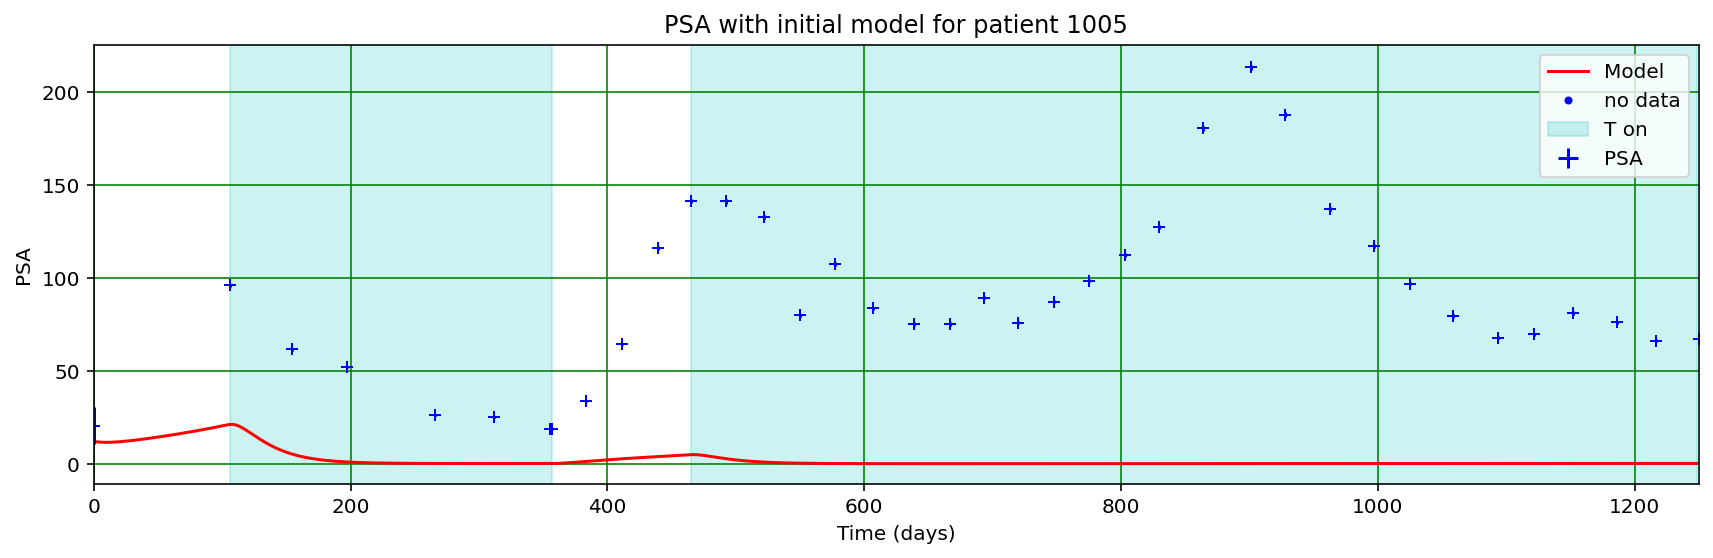

 
Fit history


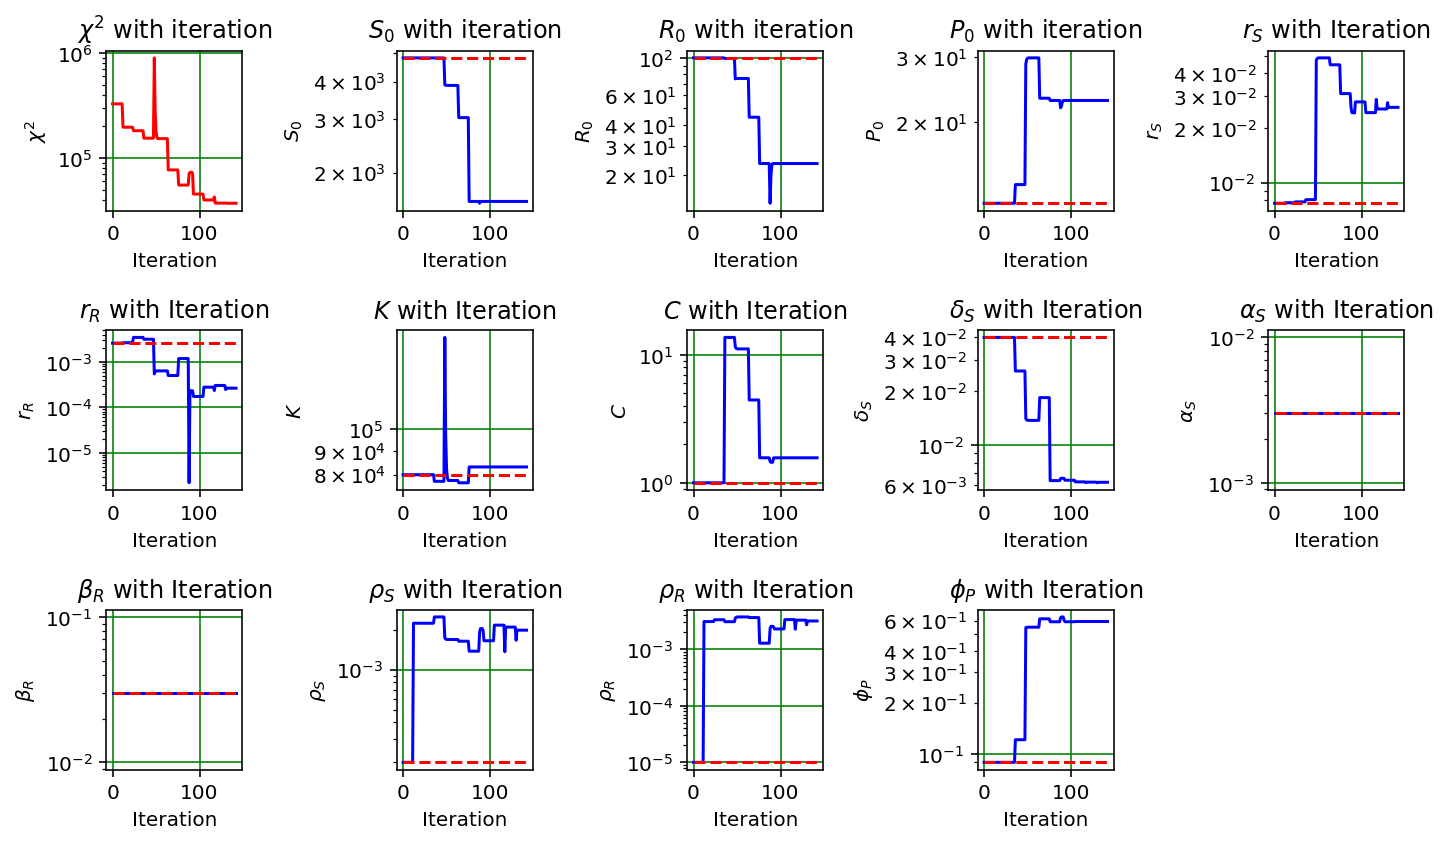

 
Fit results - chisq = 3.70e+04, chisq/NDF = 1.37e+03.
 
Fit results - returned parameters:
S0 = 1.604e+03 +- 3.177e+06 (cf. 4.80e+03)
R0 = 2.353e+01 +- 4.665e+04 (cf. 1.00e+02)
P0 = 2.286e+01 +- 1.006e+01 (cf. 1.20e+01)
rS = 2.599e-02 +- 1.28059e-03 (cf. 7.70e-03)
rR = 2.653e-04 +- 2.55356e-05 (cf. 2.60e-03)
K = 8.312e+04 +- 1.64671e+08 (cf. 8.00e+04)
C = 1.569e+00 +- 3.646e+00 (cf. 1.00e+00)
deltaS = 6.20581e-03 +- 2.454e-04 (cf. 4.00e-02)
rhoS = 1.983e-03 +- 3.929e+00 (cf. 2.00e-04)
rhoR = 3.183e-03 +- 6.305e+00 (cf. 1.00e-05)
phiP = 5.929e-01 +- 5.957e-03 (cf. 9.00e-02)
 
Patient data with fitted model
 


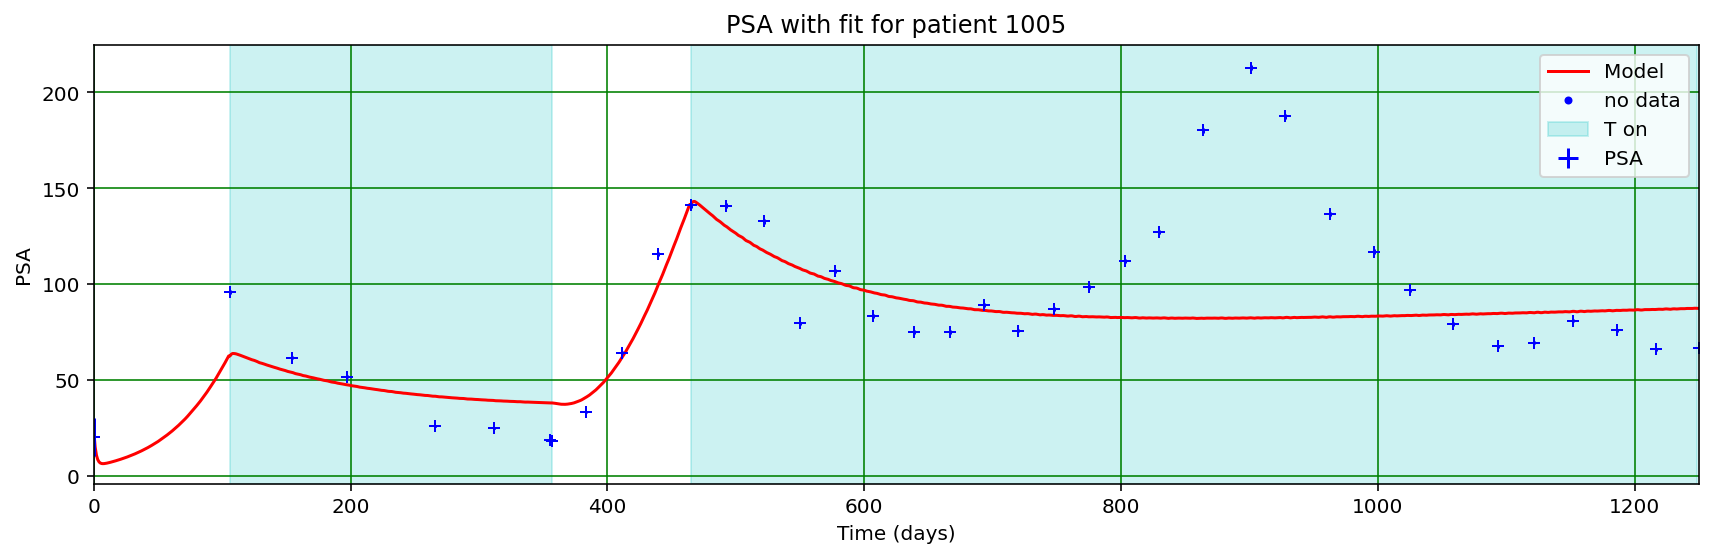

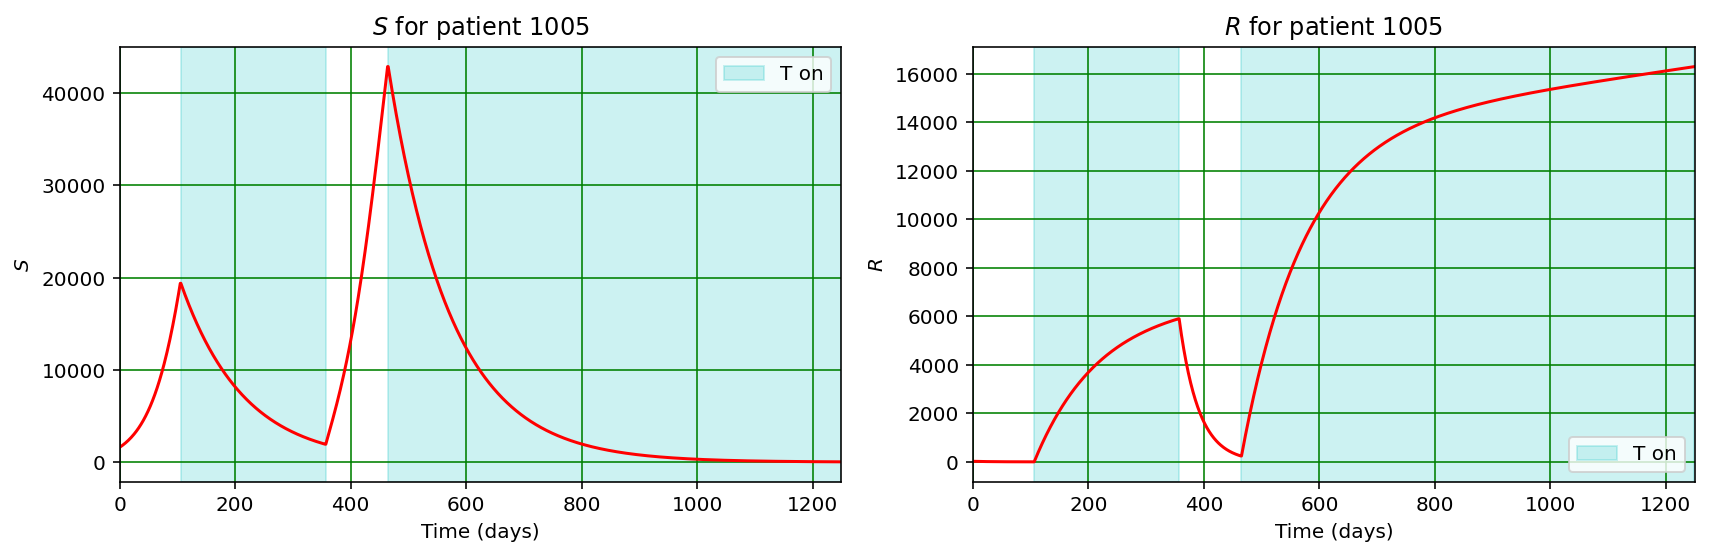

 
Analysis for index 2 , patient 1006
 
Initial PSA point given large error
 


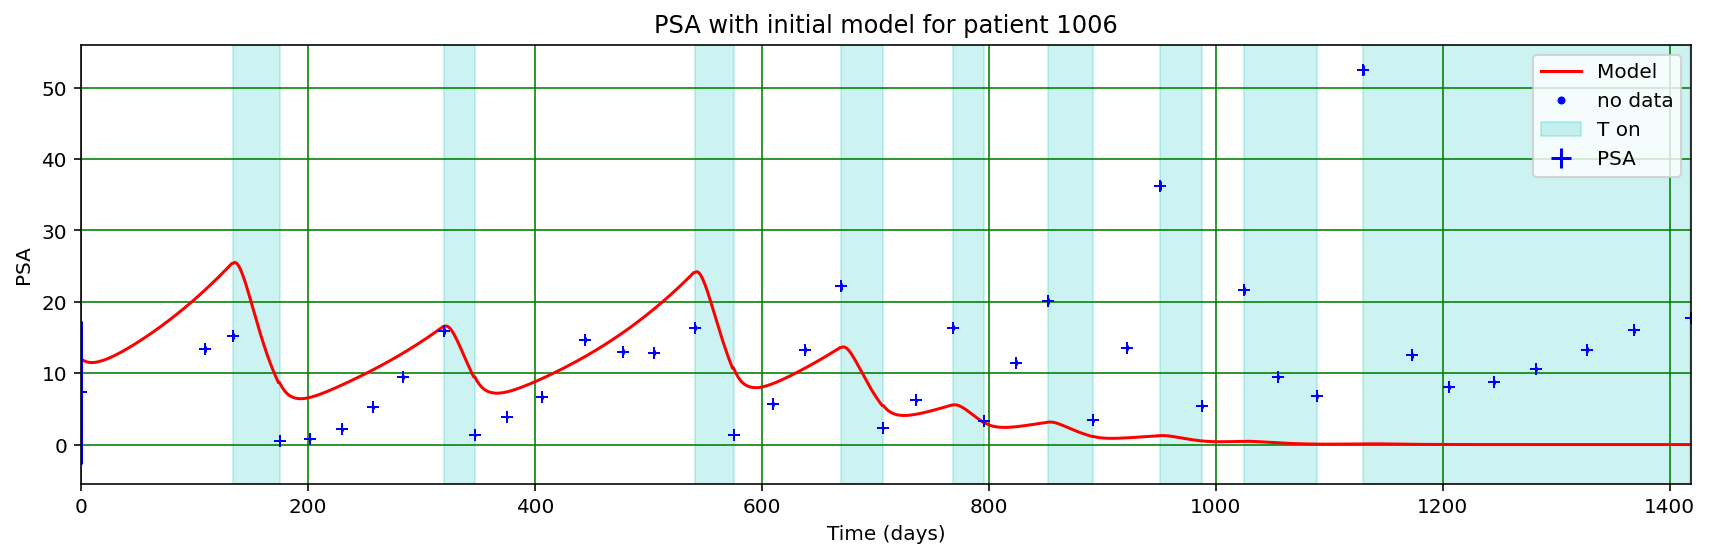

 
Fit history


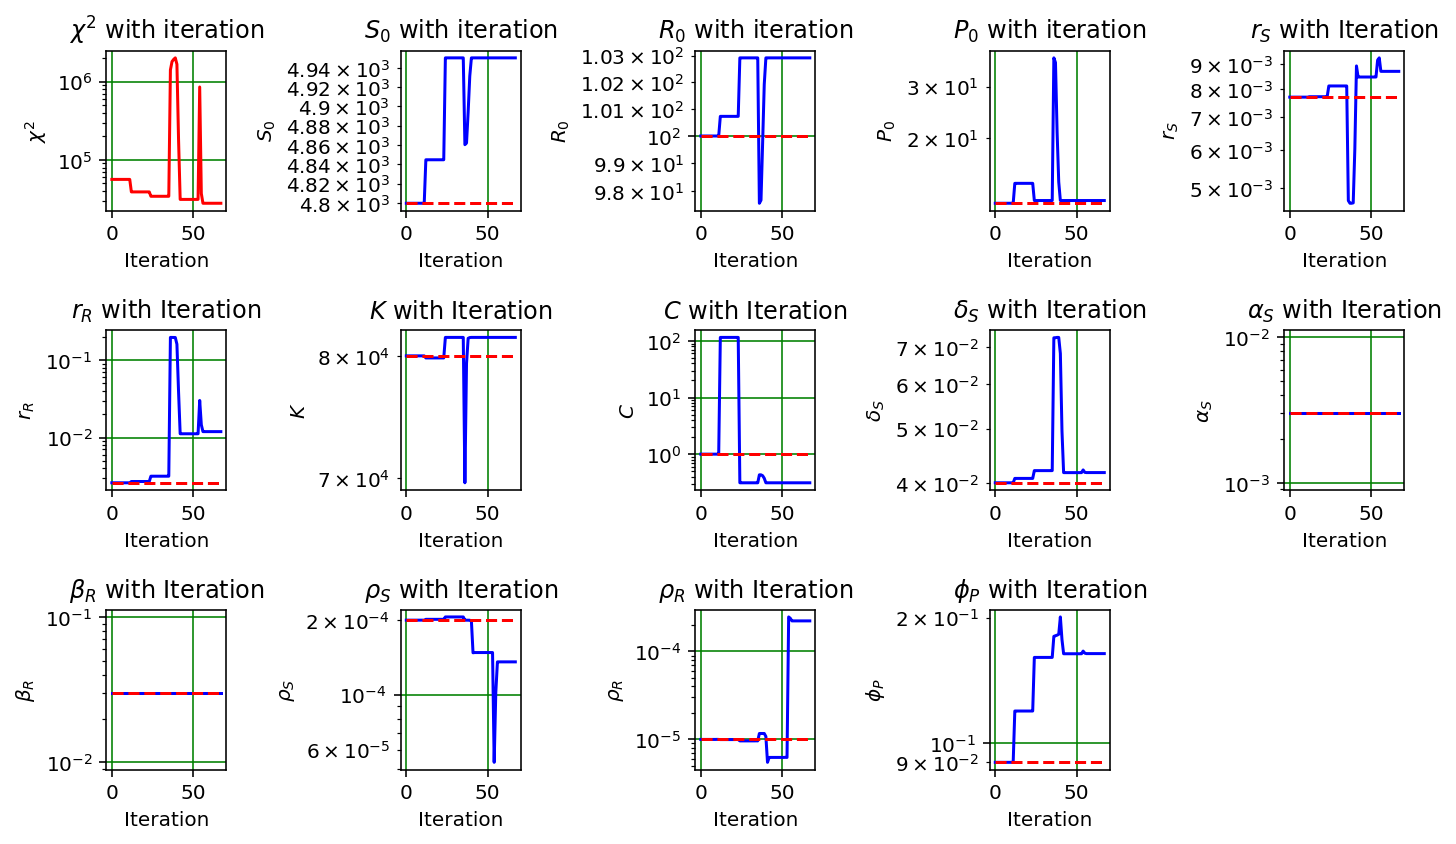

 
Fit results - chisq = 2.79e+04, chisq/NDF = 9.31e+02.
 
Fit results - returned parameters:
S0 = 4.951e+03 +- 3.077e+07 (cf. 4.80e+03)
R0 = 1.029e+02 +- 6.389e+05 (cf. 1.00e+02)
P0 = 1.226e+01 +- 9.971e+00 (cf. 1.20e+01)
rS = 8.698e-03 +- 8.47375e-04 (cf. 7.70e-03)
rR = 1.191e-02 +- 3.43227e-04 (cf. 2.60e-03)
K = 8.163e+04 +- 5.07240e+08 (cf. 8.00e+04)
C = 3.119e-01 +- 2.691e+00 (cf. 1.00e+00)
deltaS = 4.17186e-02 +- 2.368e-03 (cf. 4.00e-02)
rhoS = 1.357e-04 +- 8.431e-01 (cf. 2.00e-04)
rhoR = 2.228e-04 +- 1.384e+00 (cf. 1.00e-05)
phiP = 1.640e-01 +- 2.300e-02 (cf. 9.00e-02)
 
Patient data with fitted model
 


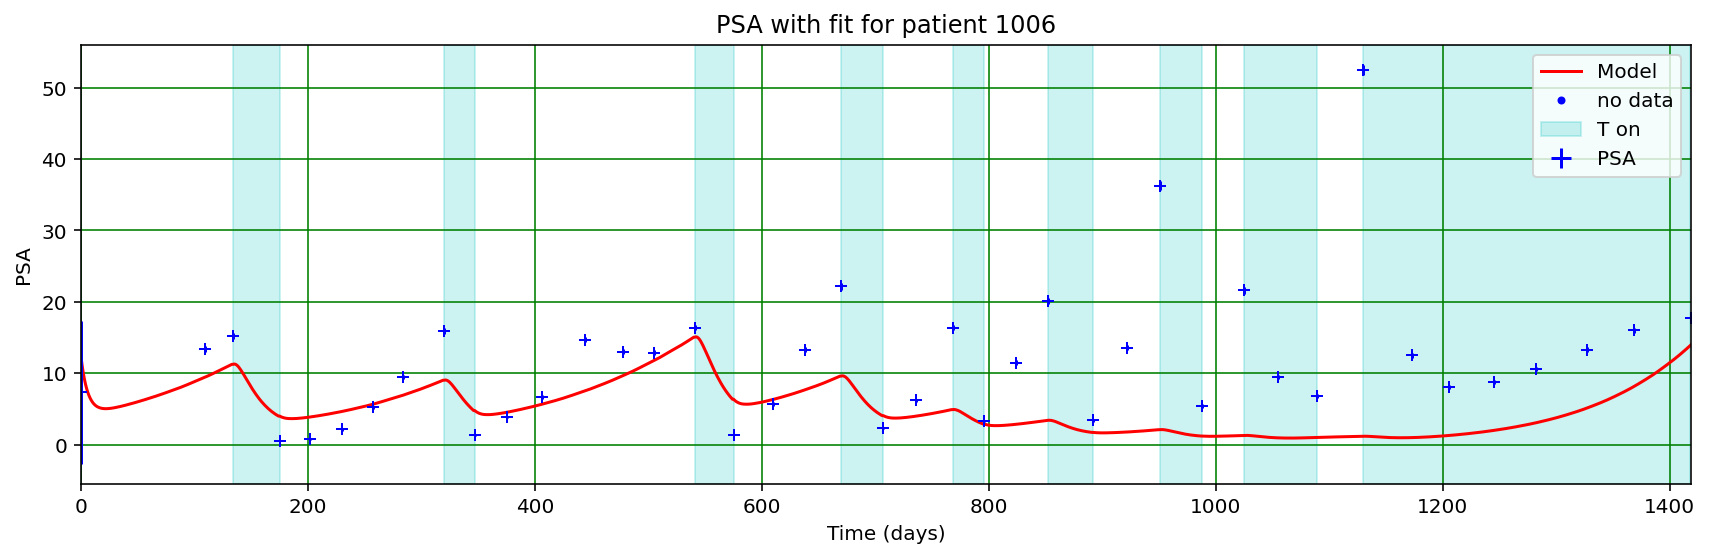

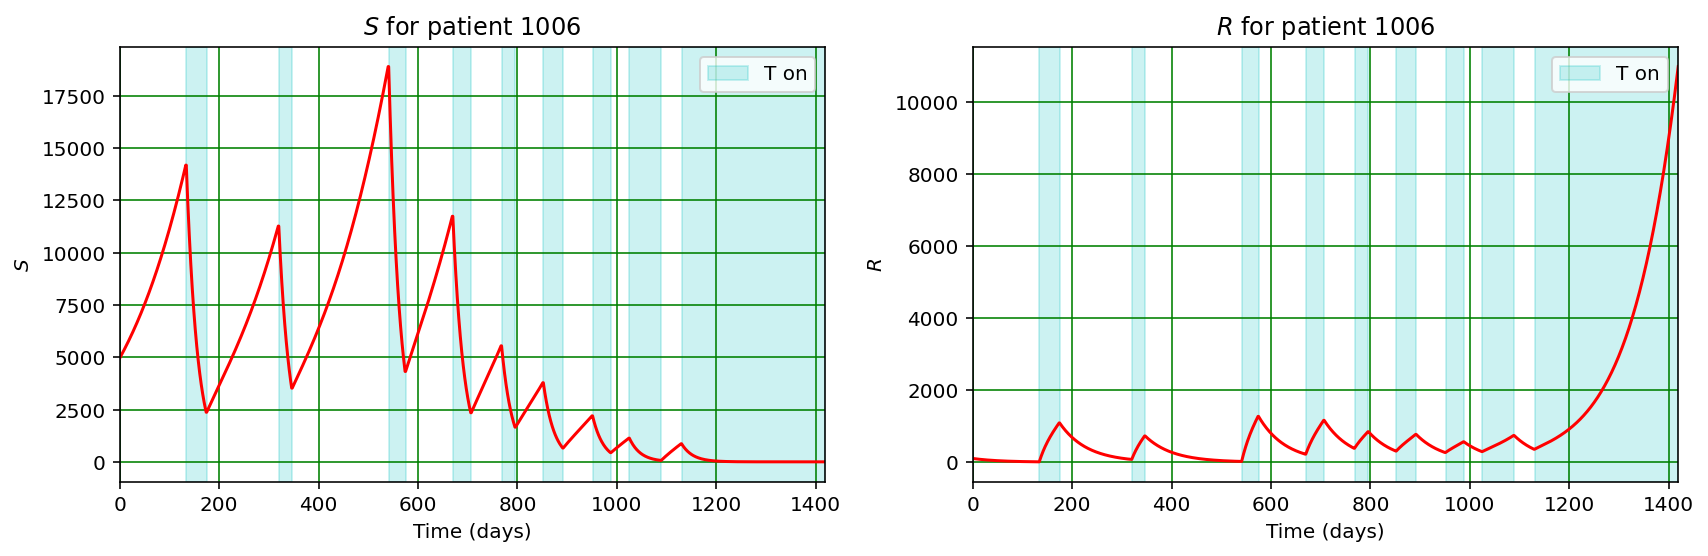

 
Analysis for index 3 , patient 1007
 
Initial PSA point given large error
 


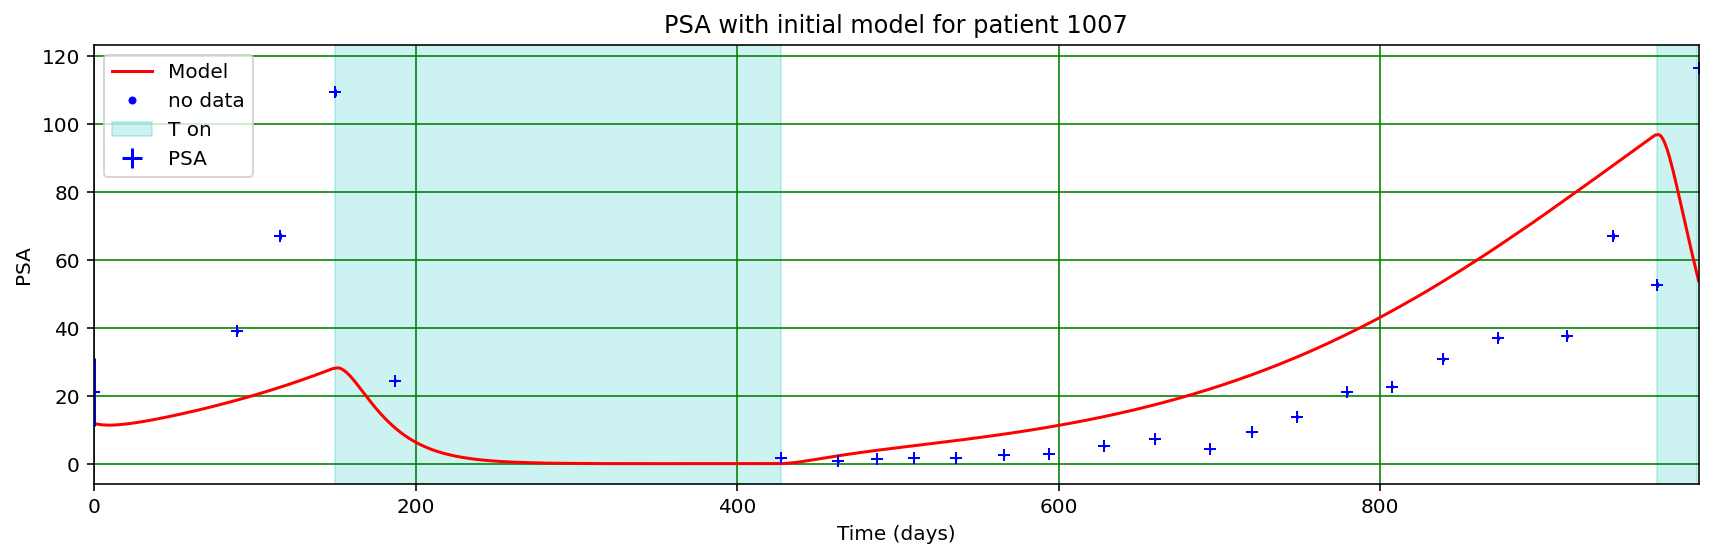

 
Fit history


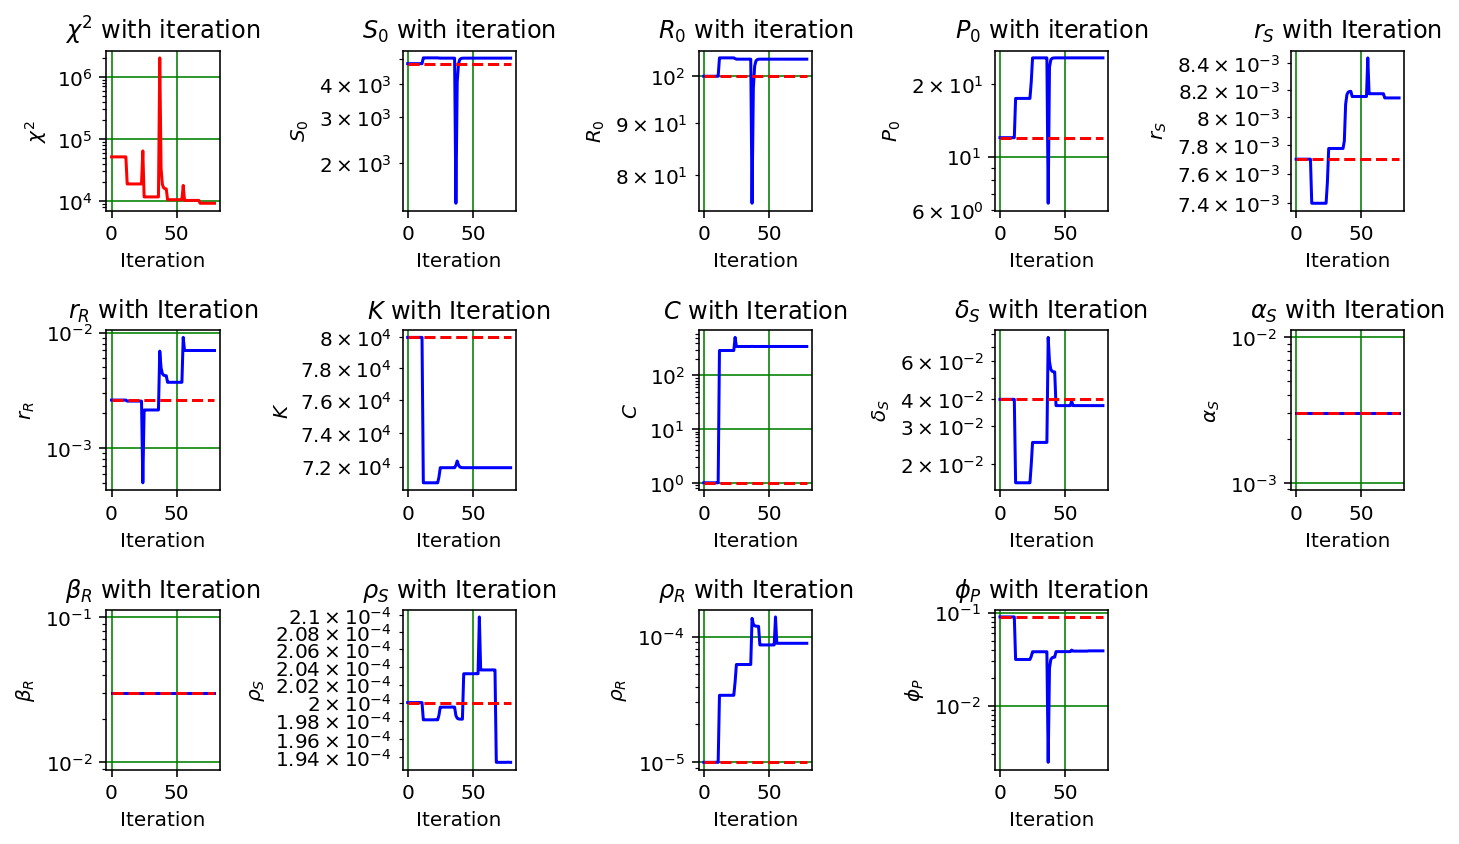

 
Fit results - chisq = 9.19e+03, chisq/NDF = 6.56e+02.
 
Fit results - returned parameters:
S0 = 5.039e+03 +- 5.110e+05 (cf. 4.80e+03)
R0 = 1.039e+02 +- 2.412e+05 (cf. 1.00e+02)
P0 = 2.575e+01 +- 1.000e+01 (cf. 1.20e+01)
rS = 8.140e-03 +- 1.46044e-04 (cf. 7.70e-03)
rR = 6.993e-03 +- 4.91297e-02 (cf. 2.60e-03)
K = 7.194e+04 +- 7.64913e+06 (cf. 8.00e+04)
C = 3.455e+02 +- 1.209e+03 (cf. 1.00e+00)
deltaS = 3.74137e-02 +- 2.219e-01 (cf. 4.00e-02)
rhoS = 1.935e-04 +- 1.993e-02 (cf. 2.00e-04)
rhoR = 8.837e-05 +- 9.114e-03 (cf. 1.00e-05)
phiP = 3.888e-02 +- 2.150e-01 (cf. 9.00e-02)
 
Patient data with fitted model
 


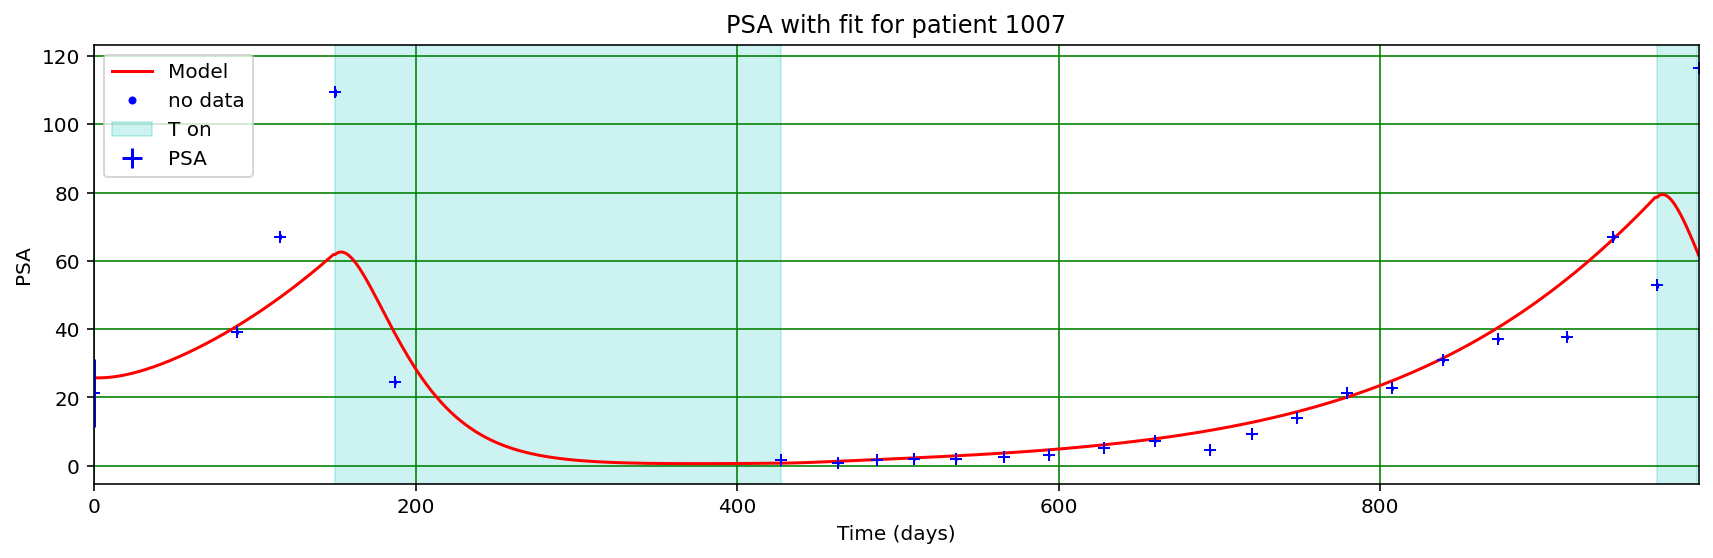

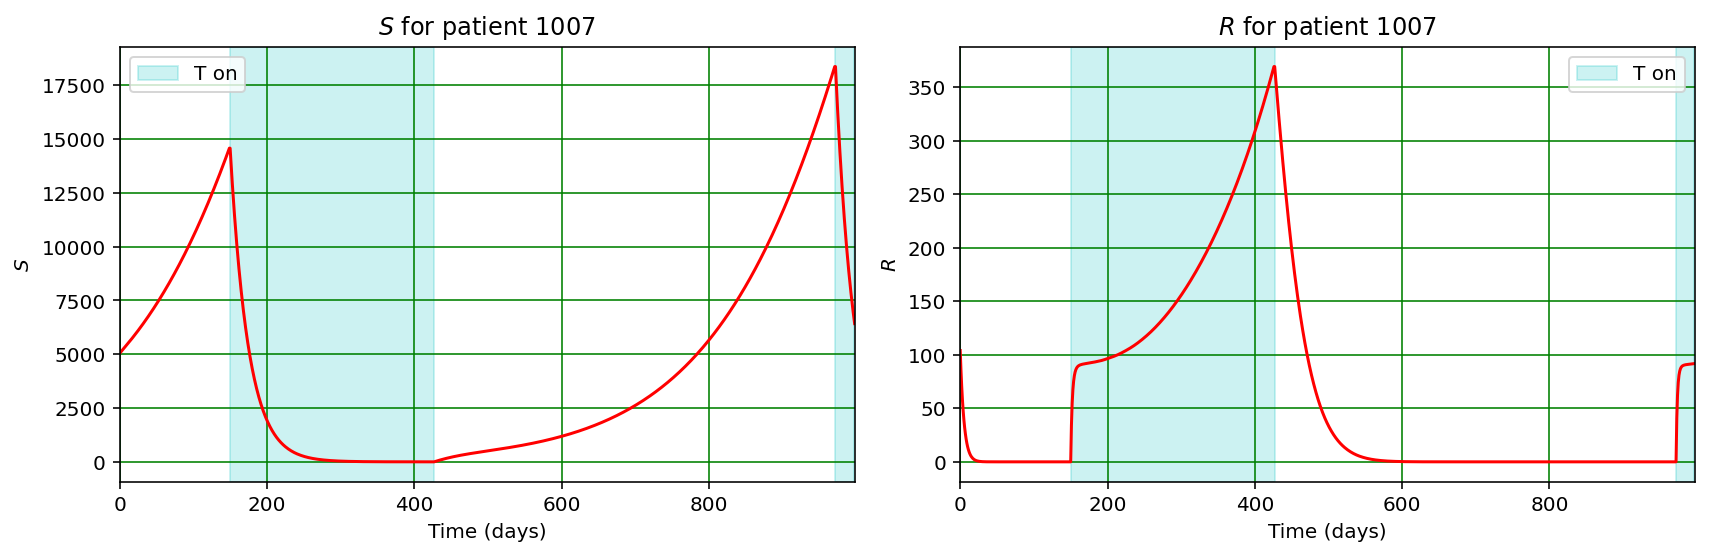

 
Analysis for index 4 , patient 2004
 
Initial PSA point given large error
 


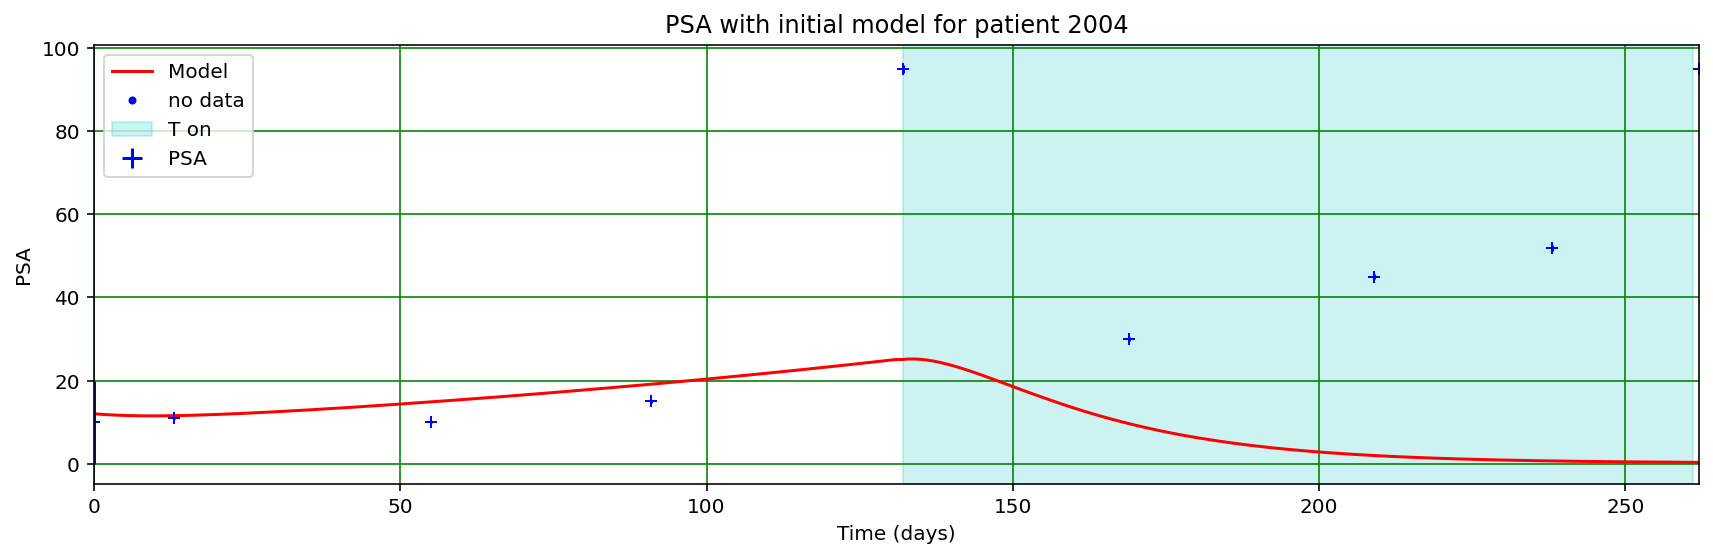

 
Fit history


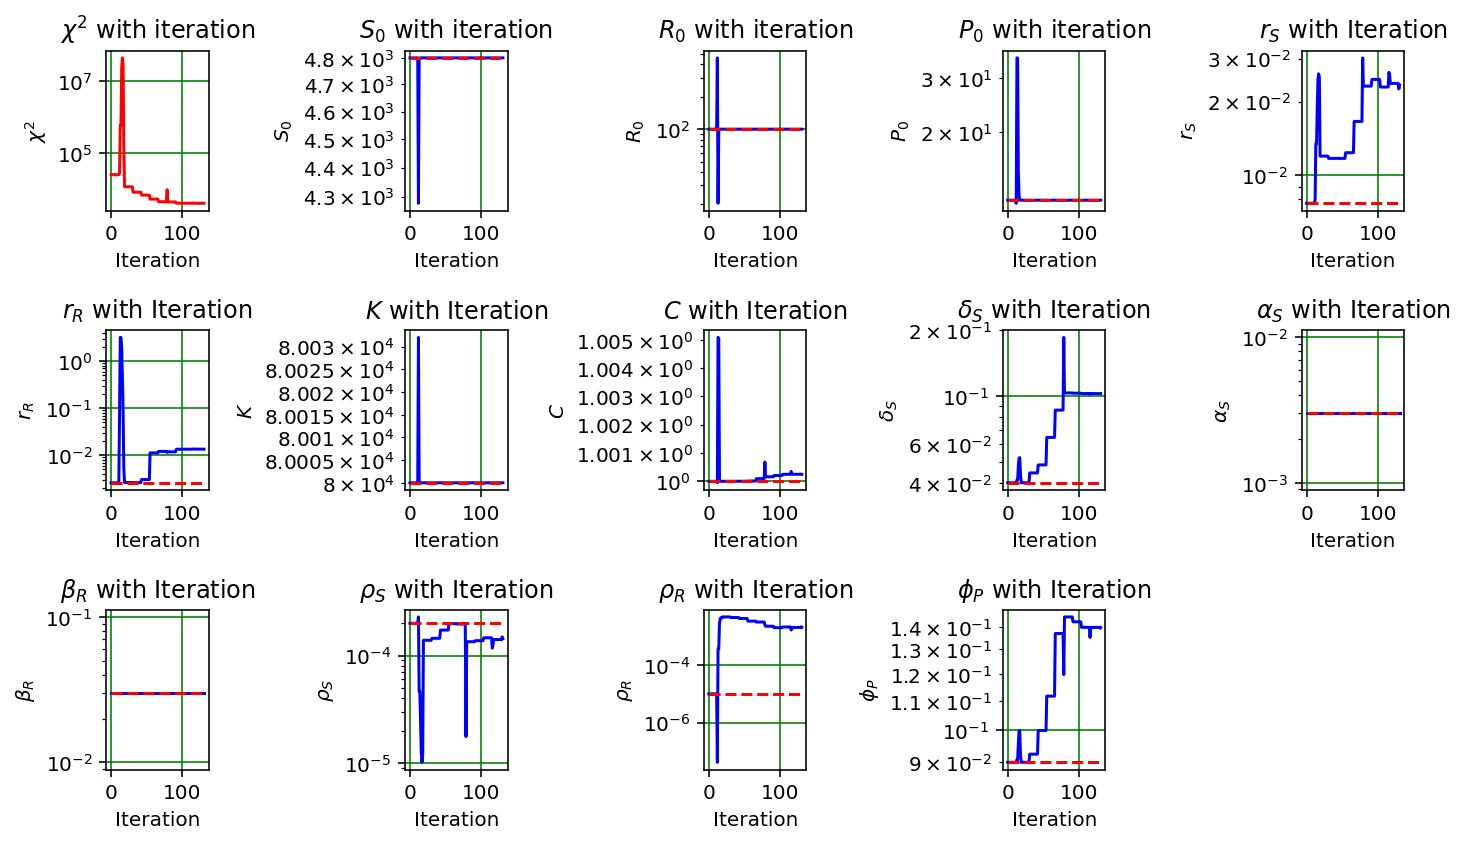

 
Fit results - chisq = 4.13e+03, chisq/NDF = -2.06e+03.
 
Fit results - returned parameters:
S0 = 4.800e+03 +- 1.838e+09 (cf. 4.80e+03)
R0 = 1.000e+02 +- 1.868e+08 (cf. 1.00e+02)
P0 = 1.200e+01 +- 3.437e+01 (cf. 1.20e+01)
rS = 2.374e-02 +- 1.29126e+03 (cf. 7.70e-03)
rR = 1.350e-02 +- 5.47840e+01 (cf. 2.60e-03)
K = 8.000e+04 +- 3.75229e+10 (cf. 8.00e+04)
C = 1.000e+00 +- 5.027e+06 (cf. 1.00e+00)
deltaS = 1.02628e-01 +- 2.773e+04 (cf. 4.00e-02)
rhoS = 1.410e-04 +- 5.548e+01 (cf. 2.00e-04)
rhoR = 2.060e-03 +- 7.844e+02 (cf. 1.00e-05)
phiP = 1.397e-01 +- 6.859e+04 (cf. 9.00e-02)
 
Patient data with fitted model
 


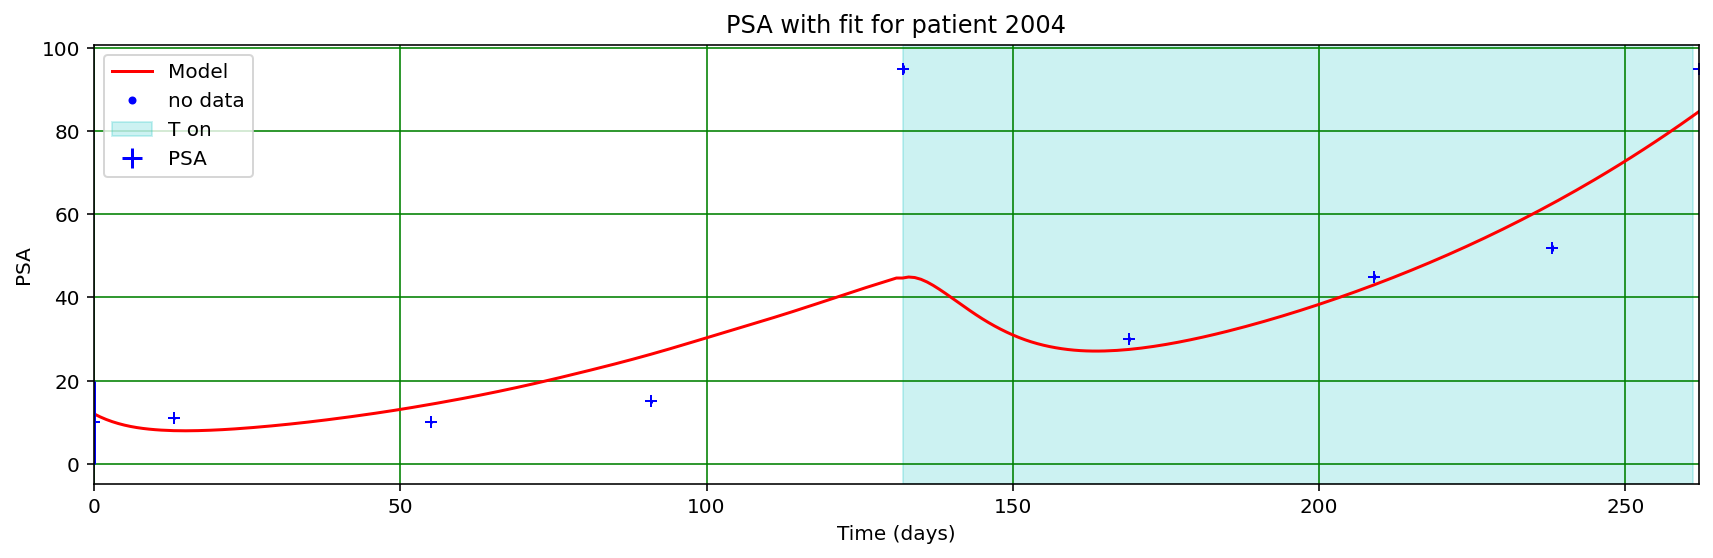

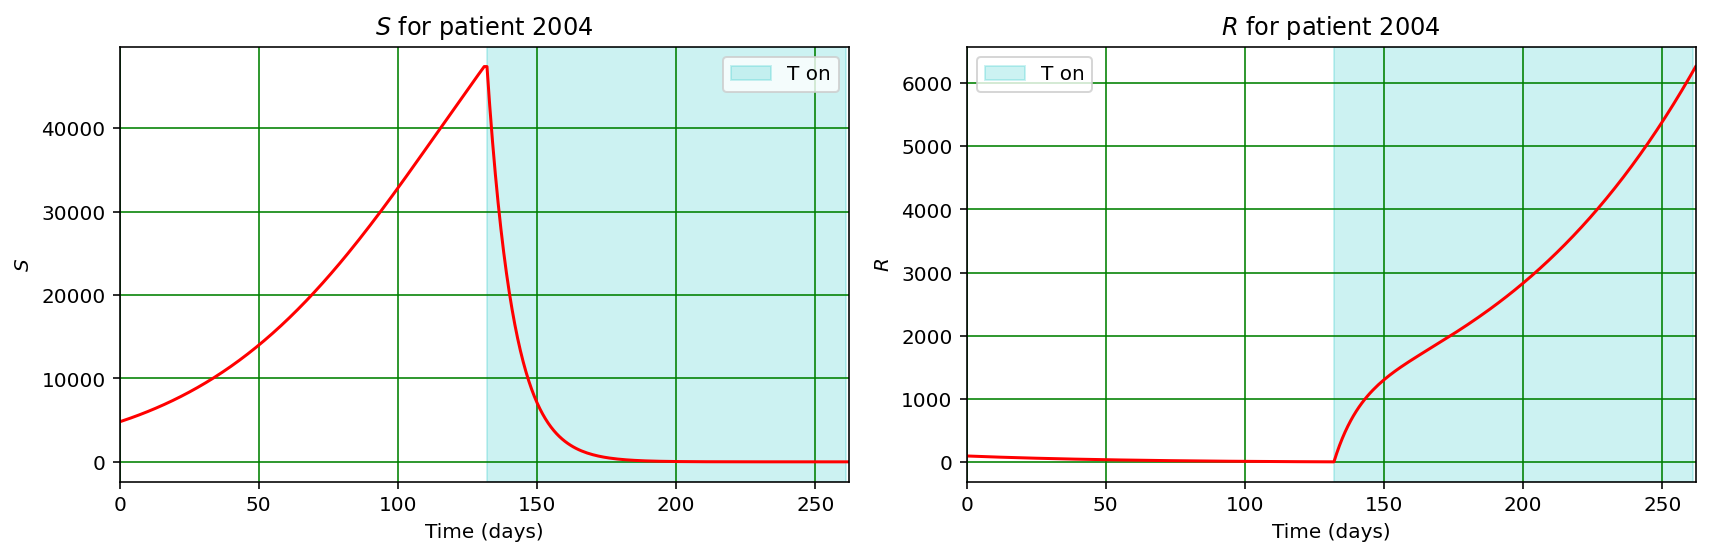

 
Analysis for index 5 , patient 2005
 
Initial PSA point given large error
 


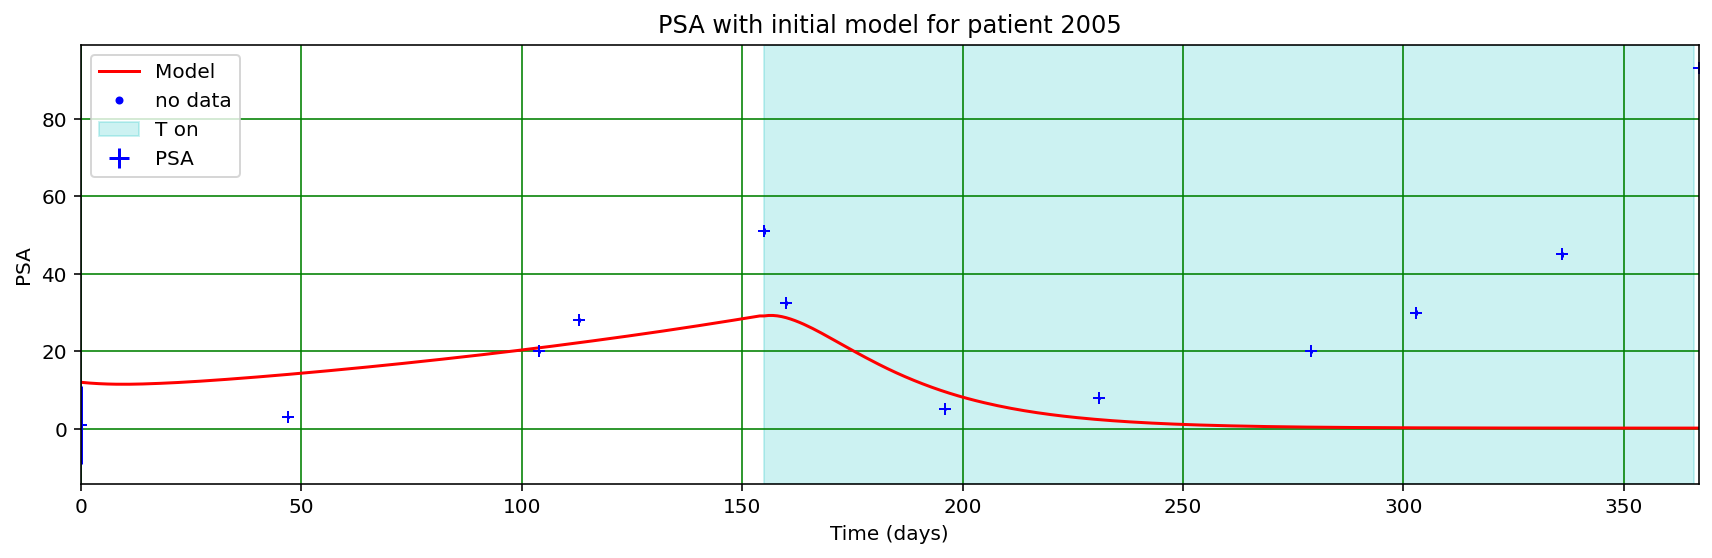

 
Fit history


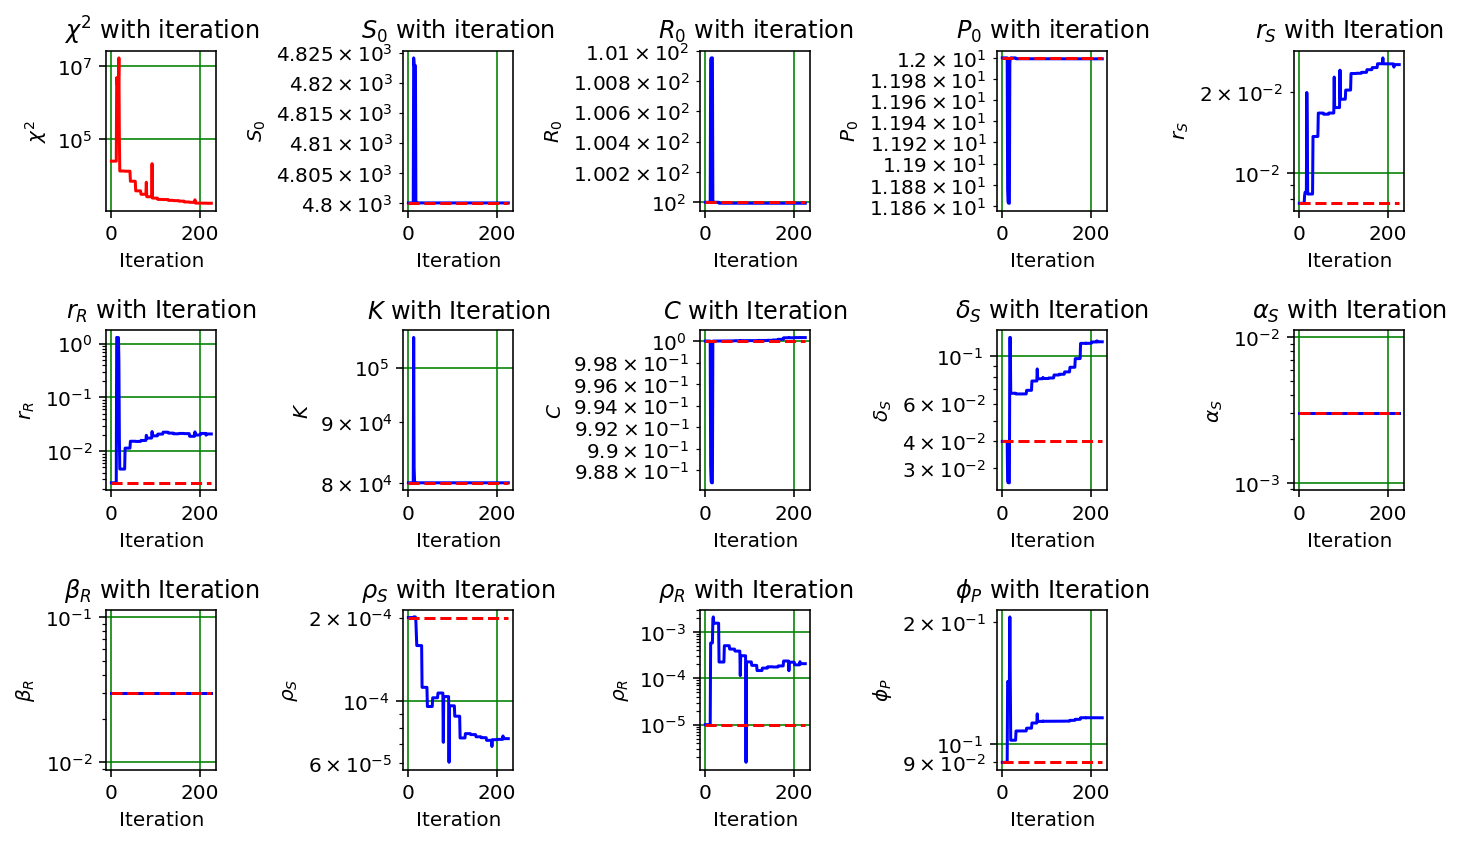

 
Fit results - chisq = 1.71e+03, chisq/NDF = 1.71e+03.
 
Fit results - returned parameters:
S0 = 4.800e+03 +- 1.076e+07 (cf. 4.80e+03)
R0 = 9.999e+01 +- 2.410e+05 (cf. 1.00e+02)
P0 = 1.200e+01 +- 1.000e+01 (cf. 1.20e+01)
rS = 2.529e-02 +- 4.67675e-02 (cf. 7.70e-03)
rR = 2.097e-02 +- 1.11720e-03 (cf. 2.60e-03)
K = 8.000e+04 +- 1.79665e+08 (cf. 8.00e+04)
C = 1.000e+00 +- 5.989e+01 (cf. 1.00e+00)
deltaS = 1.16801e-01 +- 8.735e-01 (cf. 4.00e-02)
rhoS = 7.334e-05 +- 1.653e-01 (cf. 2.00e-04)
rhoR = 2.071e-04 +- 4.665e-01 (cf. 1.00e-05)
phiP = 1.161e-01 +- 8.349e-01 (cf. 9.00e-02)
 
Patient data with fitted model
 


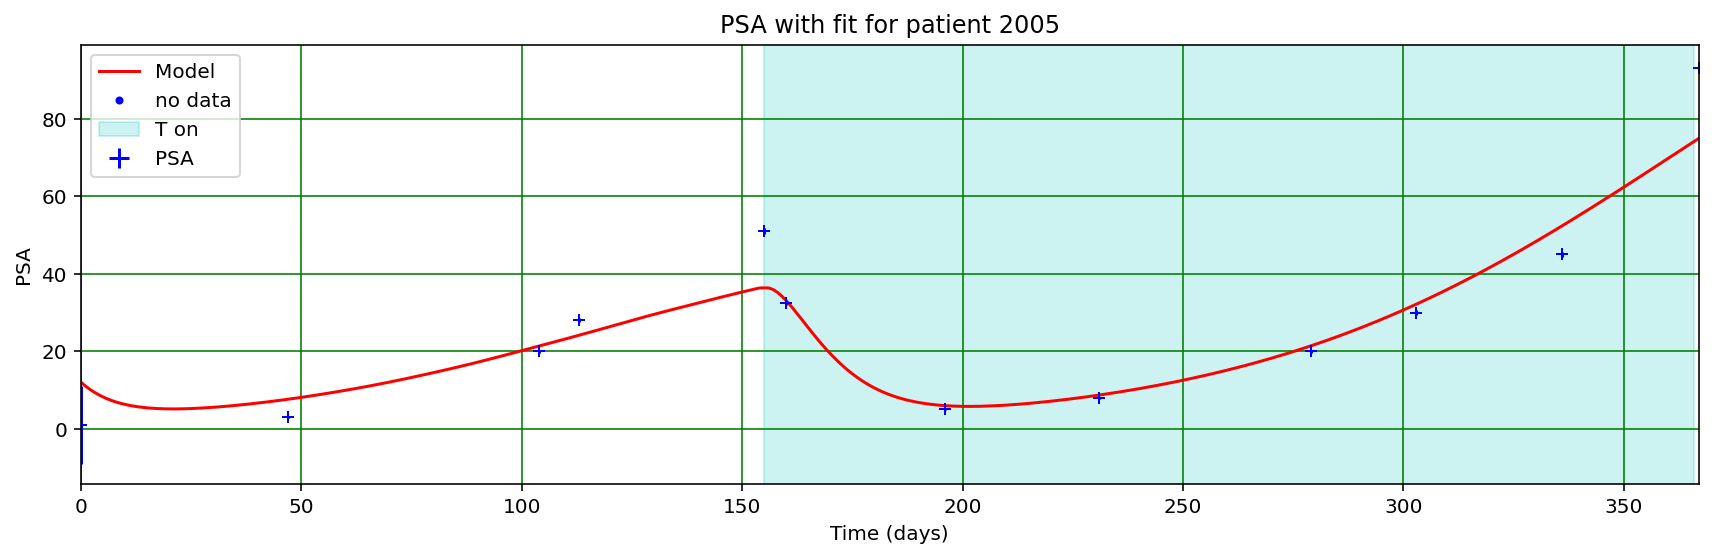

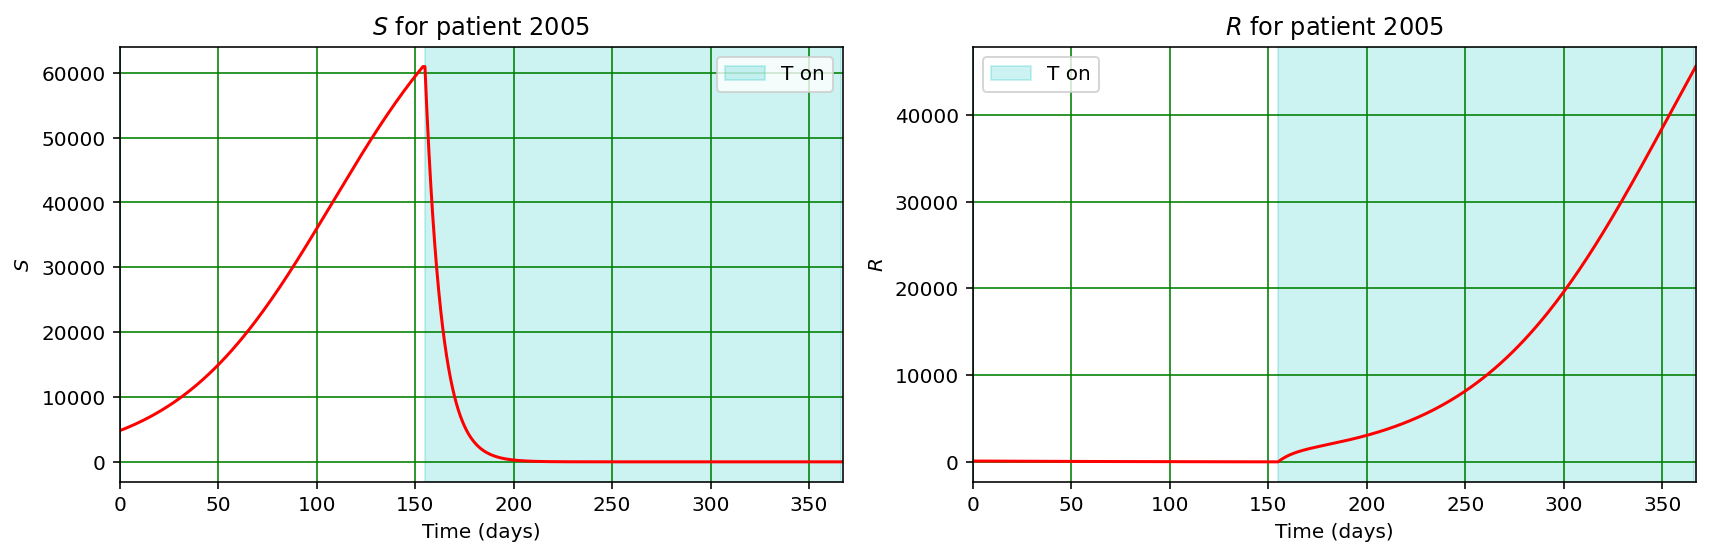

 
Analysis for index 6 , patient 2006
 
Initial PSA point given large error
 


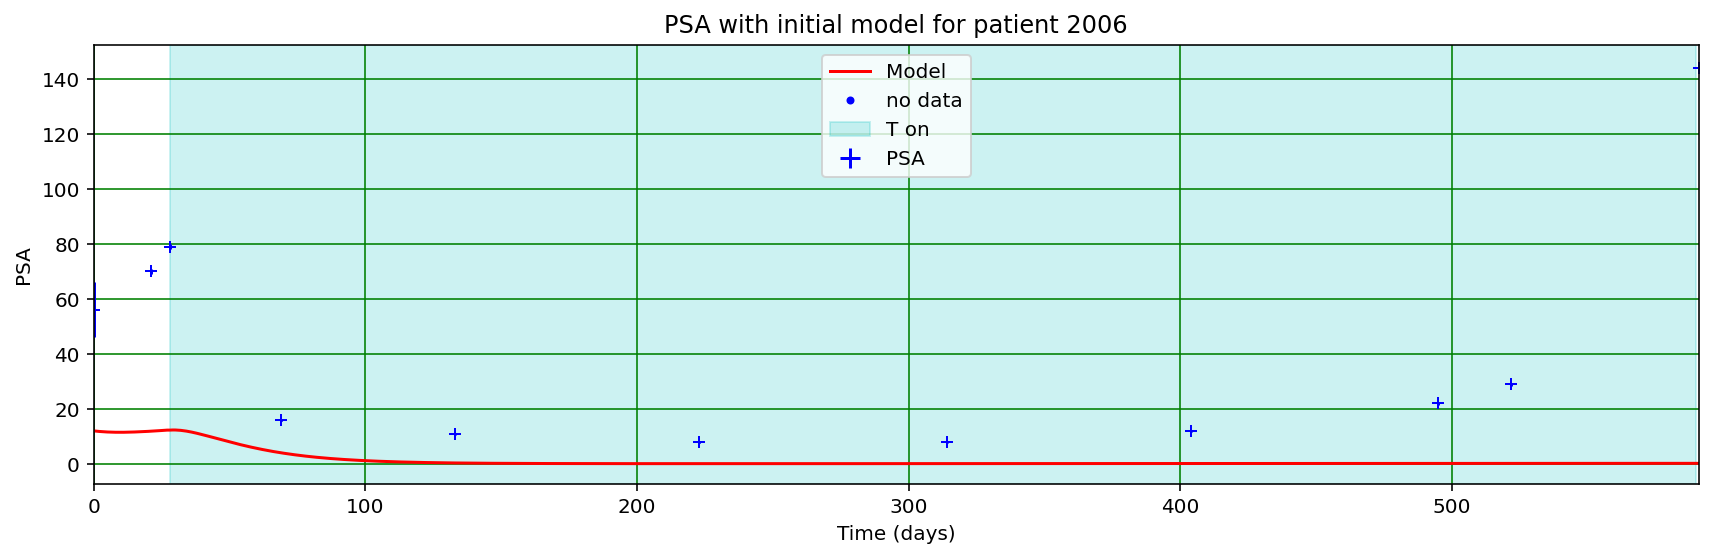

 
Fit history


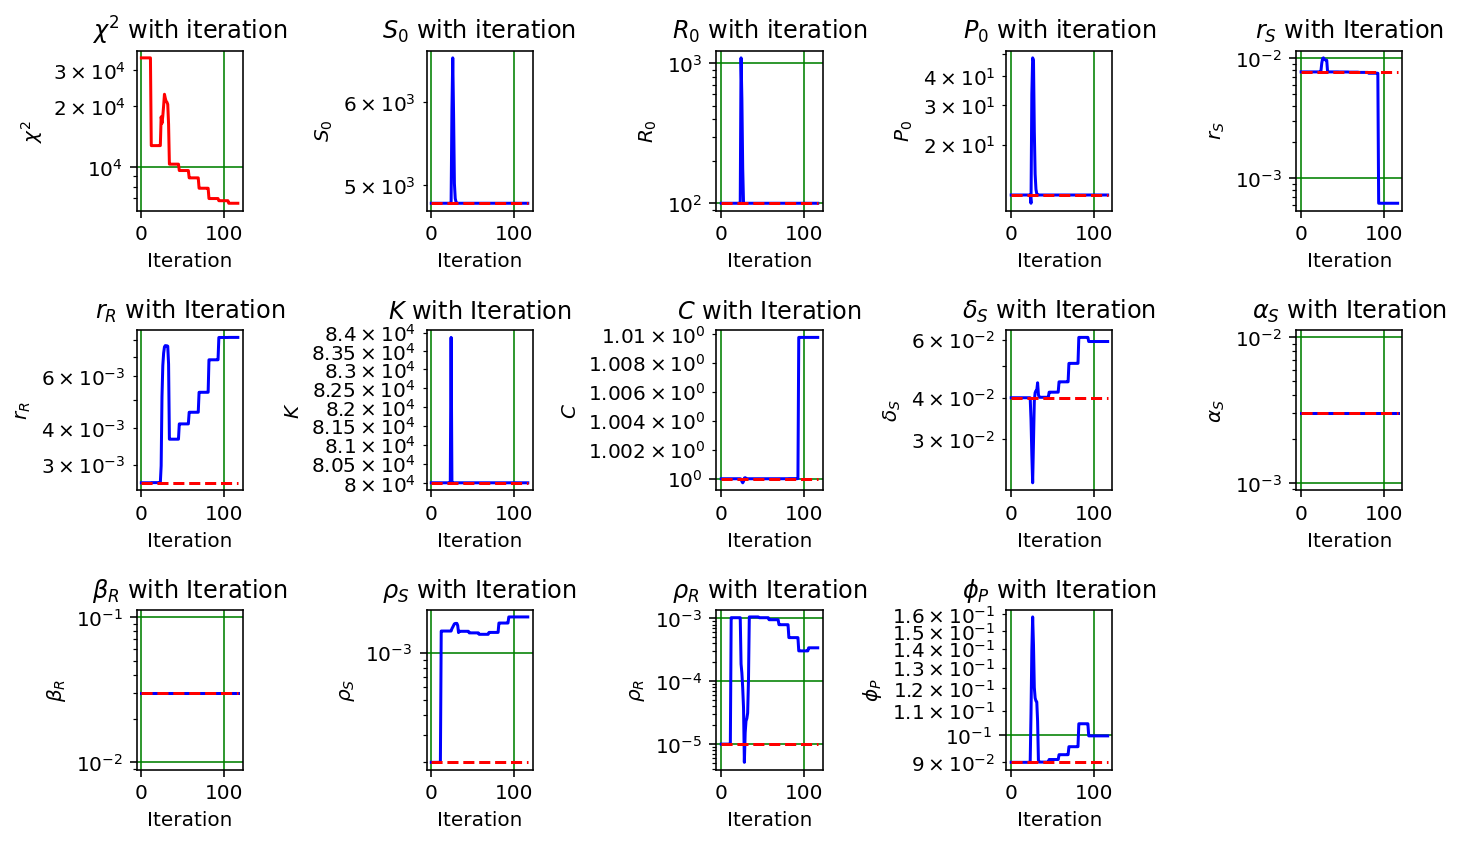

/tmp/ipykernel_1472/2174200473.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  redchisq = chisq/NDF


 
Fit results - chisq = 6.63e+03, chisq/NDF =   inf.
 
Fit results - returned parameters:
S0 = 4.800e+03 +- 3.830e+06 (cf. 4.80e+03)
R0 = 1.000e+02 +- 1.924e+06 (cf. 1.00e+02)
P0 = 1.200e+01 +- 1.429e+01 (cf. 1.20e+01)
rS = 6.201e-04 +- 6.91742e+00 (cf. 7.70e-03)
rR = 8.154e-03 +- 3.61372e-03 (cf. 2.60e-03)
K = 8.000e+04 +- 1.27633e+09 (cf. 8.00e+04)
C = 1.010e+00 +- 2.448e+06 (cf. 1.00e+00)
deltaS = 5.92293e-02 +- 2.695e+00 (cf. 4.00e-02)
rhoS = 1.689e-03 +- 1.068e+00 (cf. 2.00e-04)
rhoR = 3.406e-04 +- 5.444e+00 (cf. 1.00e-05)
phiP = 9.973e-02 +- 3.727e+00 (cf. 9.00e-02)
 
Patient data with fitted model
 


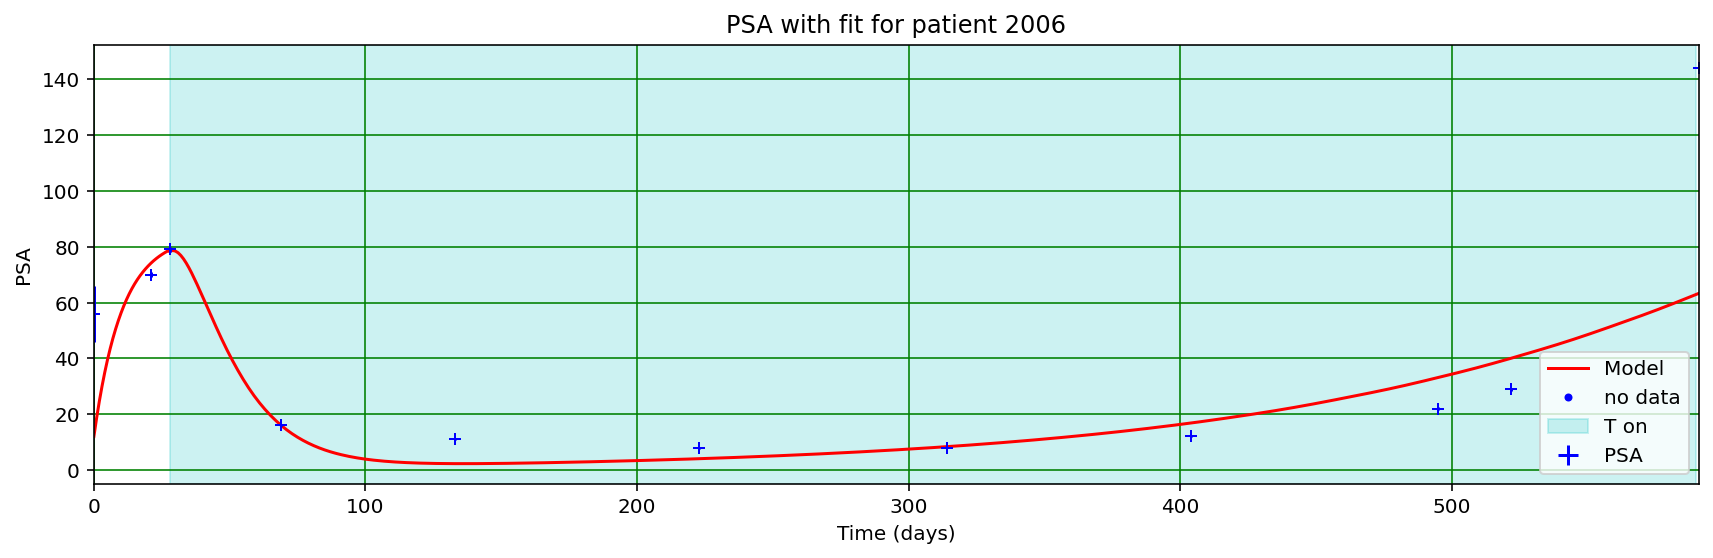

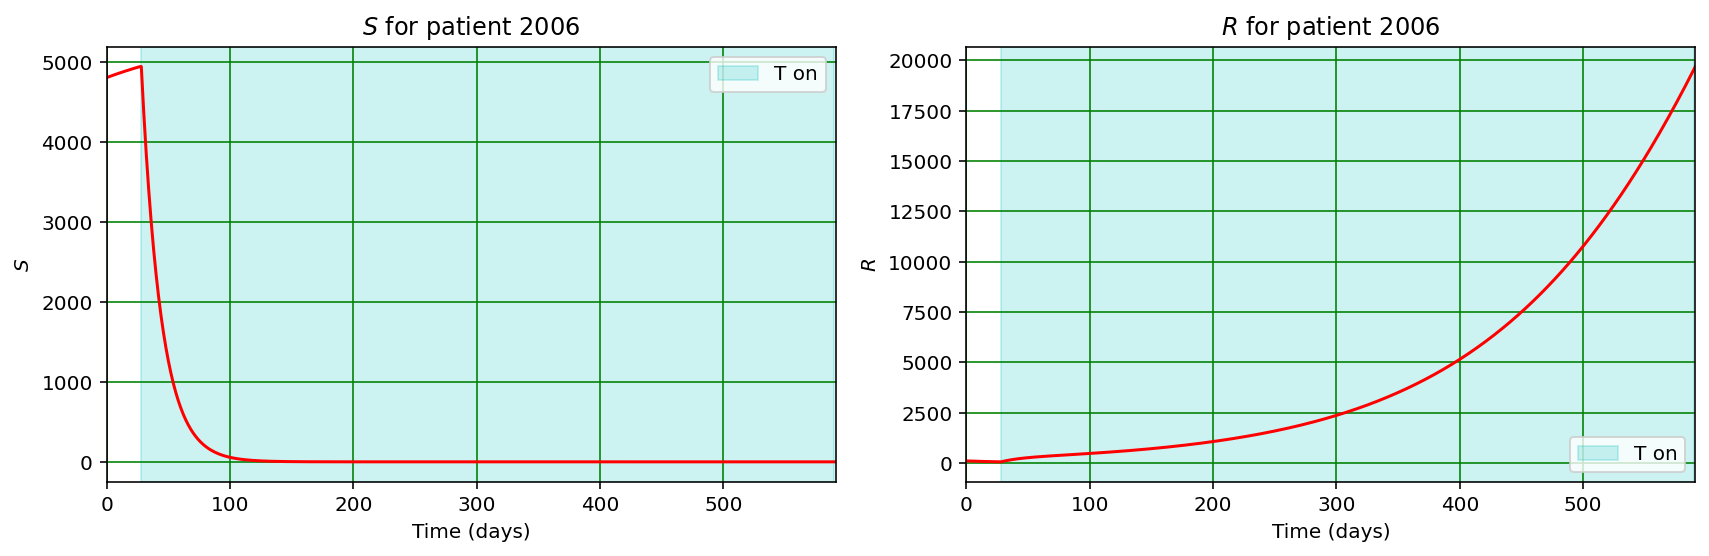

 
Analysis for index 7 , patient 2007
 
Initial PSA point given large error
 


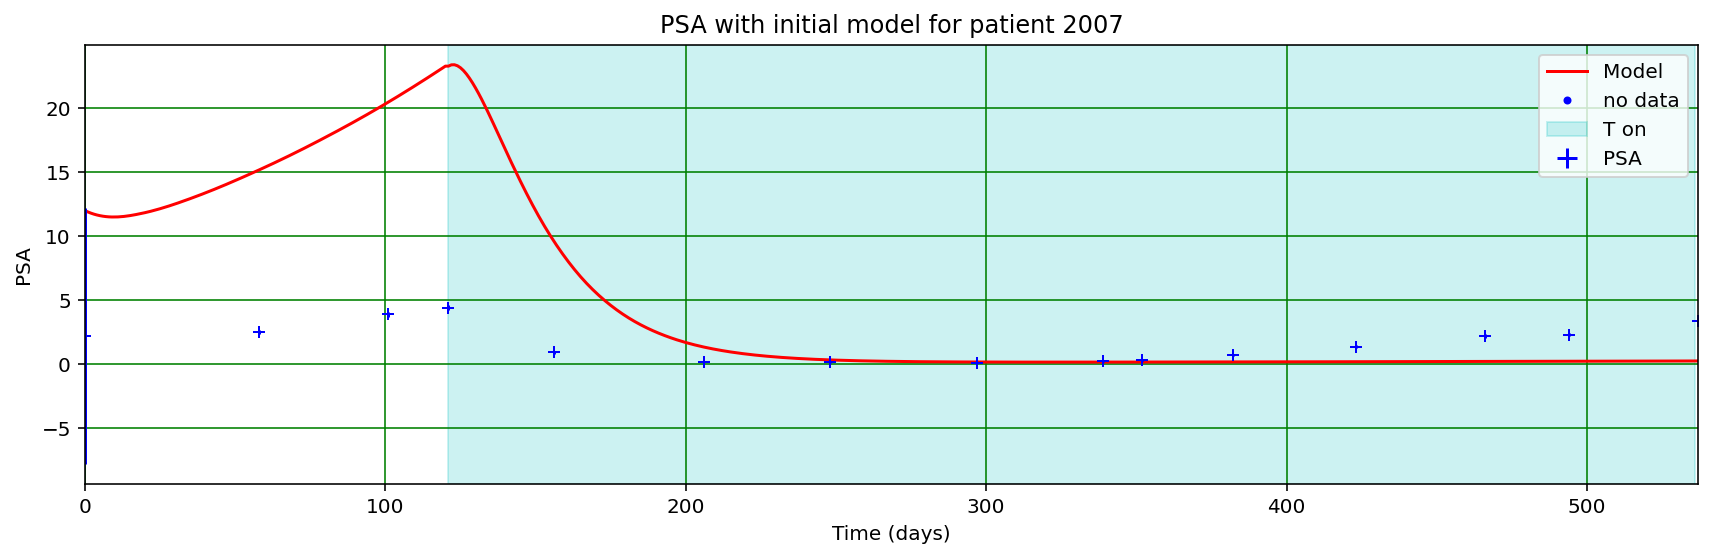

 
Fit history


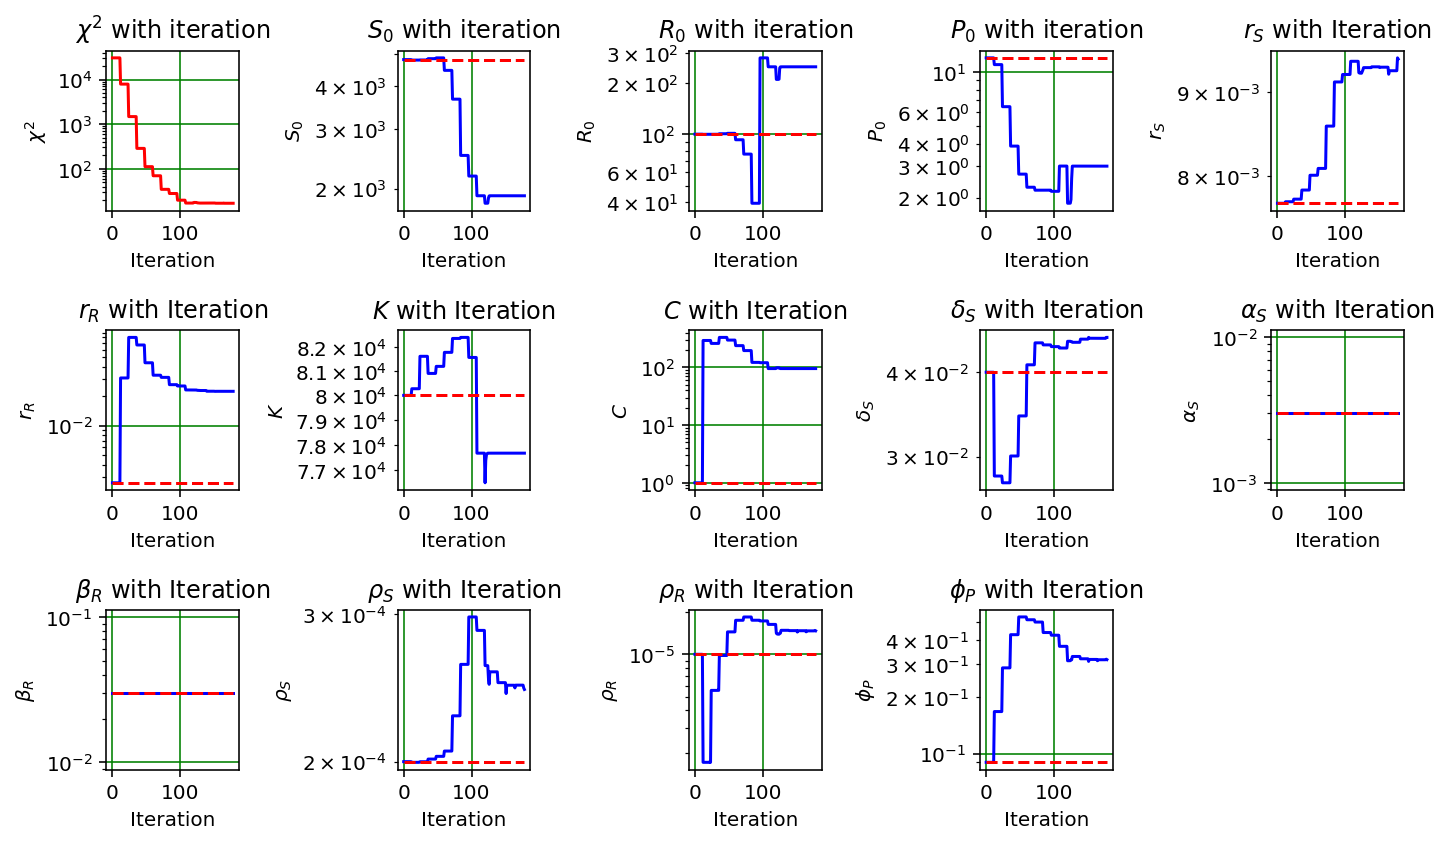

 
Fit results - chisq = 1.69e+01, chisq/NDF = 4.21e+00.
 
Fit results - returned parameters:
S0 = 1.907e+03 +- 2.297e+07 (cf. 4.80e+03)
R0 = 2.482e+02 +- 5.966e+06 (cf. 1.00e+02)
P0 = 2.996e+00 +- 1.000e+01 (cf. 1.20e+01)
rS = 9.273e-03 +- 1.27804e-01 (cf. 7.70e-03)
rR = 2.247e-02 +- 2.83475e-03 (cf. 2.60e-03)
K = 7.768e+04 +- 9.96152e+08 (cf. 8.00e+04)
C = 9.525e+01 +- 3.172e+03 (cf. 1.00e+00)
deltaS = 4.49078e-02 +- 2.261e-02 (cf. 4.00e-02)
rhoS = 2.468e-04 +- 3.118e+00 (cf. 2.00e-04)
rhoR = 1.466e-05 +- 1.880e-01 (cf. 1.00e-05)
phiP = 3.154e-01 +- 5.538e-01 (cf. 9.00e-02)
 
Patient data with fitted model
 


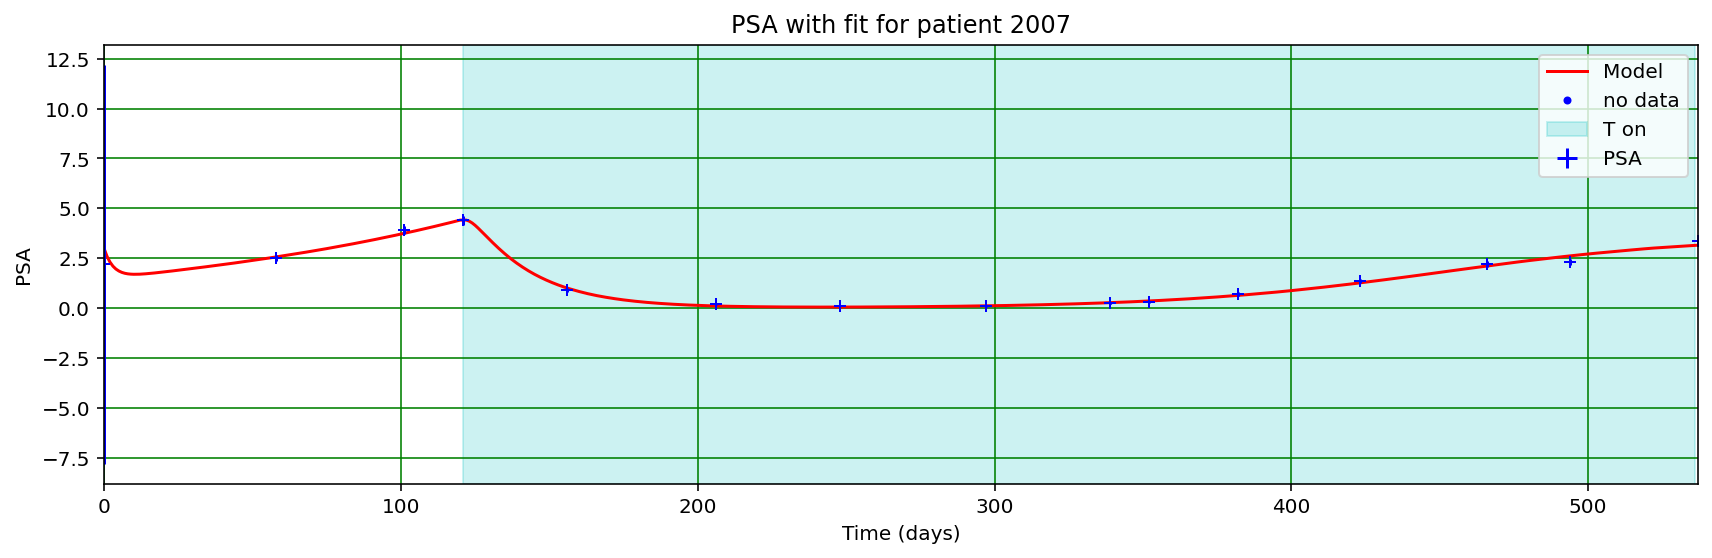

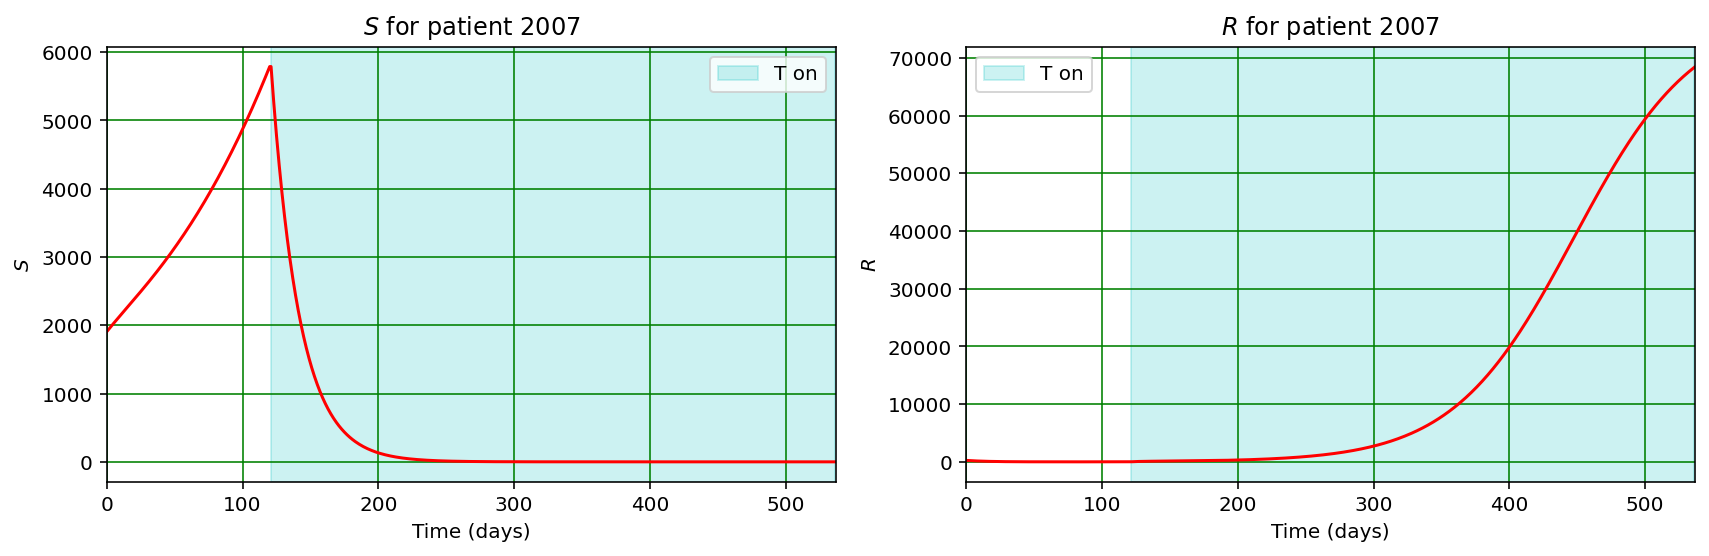

 
Date and time 2024-05-10 16:04:19.992649
Time since last check is 0:00:58.203990
Time since notebook start is 0:00:58.203990


In [13]:
import datetime
now = datetime.datetime.now()
nbstart = now
print("Date and time ",str(now))
#
verbose = False
#
# Use MC
MonteCarlo = False
#
# Use MC parameters to initialise fit (for data )
use_MC_init = False
#
# Use fit parameters to initialise fit
use_fitoutput = False
#
# Choose parameters to fit
LVmode = True
#
if LVmode:
    use_rS = True
    use_rR = True
    use_K = True
    use_C = True
    use_deltaS = True
    use_alphaS = False  # must be False
    use_betaR = False   # must be False
    use_rhoS = True
    use_rhoR = True
    use_phiP = True
else:
    use_rS = True
    use_rR = True
    use_K = True
    use_C = False       # Must be false and must have C_ini = 1
    use_deltaS = True
    use_alphaS = True
    use_betaR = True
    use_rhoS = False
    use_rhoR = True
    use_phiP = True
#
n_params = (3 + use_rS + use_rR + use_K + use_C + use_deltaS + use_alphaS + 
            use_betaR + use_rhoS + use_rhoR + use_phiP)
#
# Initialise random number generator
rng = np.random.default_rng(123)
#

patient_list = [1004,1005,1006,1007,2004,2005,2006,2007]  #Patients of Interest
#
num_patients = len(patient_list)
#
S0vals = []
R0vals = []
P0vals = []
rSvals = []
rRvals = []
Kvals = []
Cvals = []
deltaSvals = []
alphaSvals = []
betaRvals = []
rhoSvals = []
rhoRvals = []
phiPvals = []
chiSqvals = []
#
# Read first patient data and set up some dataframes
patient = patient_list[0]
header_df, patient_df, init_file = ReadInitialRecord(MonteCarlo, patient)
#
# Initialise variables for fit and their lower and upper bounds 
(pIn, lBs, uBs, S0_ini, R0_ini, P0_ini, rS_ini, rR_ini, 
 K_ini, C_ini, deltaS_ini, alphaS_ini, betaR_ini, rhoS_ini, rhoR_ini, phiP_ini) = \
prepareFit(MonteCarlo, use_MC_init, use_fitoutput, init_file)
#
for n in range(0, num_patients):
    patient = patient_list[n]
    print(" ")
    print("=================================================================================================================")
    print("Analysis for index",n,"\b, patient",patient)
    #
    # Read data for current patient
    out_file, this_patient_df = ReadPatientRecord(patient_df, patient)
    #
    # Set up arrays required for fit
    (meas_days, PSA_data, treat_period, treat_day, xData, yData, xError, yError,
     n_data_points, n_periods, t_end, t_start) = patientData(patient, this_patient_df)
    #
    if verbose:
        print(" ")
        print("Patient data - plots")
        plotData(patient, meas_days, PSA_data, treat_period)
        #
        print(" ")
        print("Patient data - listings")
        listDataXY(patient, this_patient_df, meas_days, PSA_data, treat_day, xData, yData, xError, yError)
    #
    # Calculate model using initial parameters
    n_meas_days = len(meas_days)
    n_days = meas_days[n_meas_days - 1]
    #
    t_all, T_all, Sarr_i, Rarr_i, PSA_i, dP_all = \
    theModel(n_days, n_periods, t_start, t_end, treat_day, S0_ini, R0_ini, P0_ini, 
             rS_ini, rR_ini, K_ini, C_ini, deltaS_ini, alphaS_ini, betaR_ini, rhoS_ini, rhoR_ini, phiP_ini)
    #
    # Plot initial model PSA values and (if required) initial sensitive and resistant cell numbers
    fit_done = False
    full_model = False
    plotDataModel(patient, fit_done, full_model, meas_days, PSA_data, treat_day, Sarr_i, Rarr_i, PSA_i,
                  xData, yData, xError, yError)
    #
    # Define global chi2 and parameter history lists and do fit
    chi2global = []
    S0hist = []
    R0hist = []
    P0hist = []
    rShist = []
    rRhist = []
    Khist = []
    Chist = []
    deltaShist = []
    alphaShist = []
    betaRhist = []
    rhoShist = []
    rhoRhist = []
    phiPhist = []
    #
    Sarr_f, Rarr_f, PSA_f = doFit(patient, meas_days, xData, yData, xError, yError, pIn, lBs, uBs)
    #
    # Plot fitted PAS values and (if required) sensitive and resistant cell numbers
    full_model = True
    fit_done = True
    print(" ")
    print("Patient data with fitted model")
    plotDataModel(patient, fit_done, full_model, meas_days, PSA_data, treat_day, Sarr_f, Rarr_f, PSA_f,
                 xData, yData, xError, yError)
    #
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - nbstart))